In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from psfutil_1d import *

In [2]:
BAND = "H158"

psf_in = psf_single_slit(LDP[BAND])
psf_in_t = np.fft.rfft(np.fft.ifftshift(psf_in))
psf_inp = pixelate_psf(psf_in)
psf_inp_t = np.fft.rfft(np.fft.ifftshift(psf_inp))

# Let's try a wider target output PSF, and thus a wider weight field.
psf_out = psf_gaussian(SIGMA[BAND] * 2)
psf_out_t = np.fft.rfft(np.fft.ifftshift(psf_out))
weight_t = psf_out_t / psf_inp_t  # 9/7/2025
weight_t[NPIX::] = 0; weight_t.imag = 0
weight = np.fft.ifftshift(np.fft.irfft(weight_t, n=NTOT))

/tmp/ipykernel_20995/3225394591.py:11: RuntimeWarning: invalid value encountered in divide
  weight_t = psf_out_t / psf_inp_t  # 9/7/2025


In [3]:
ovl_ii = psf_overlap(psf_inp, psf_inp)  # A matrix.
assert np.allclose(ovl_ii[1:], ovl_ii[:0:-1])
ovl_oi = psf_overlap(psf_out, psf_inp)  # -B/2 matrix.
ovl_oo = psf_overlap(psf_out, psf_out)  # Center is C.
print(C := ovl_oo[NTOT//2], square_norm(psf_out))

4.831145238312438 4.831145238312438


In [4]:
# Same as the last figure in 2025.09.05 imcom_1d.ipynb.
# Amat, Ainv, Bmat, Tmat = explore_case(ovl_ii, ovl_oi, shifts=[0], aspect=13)

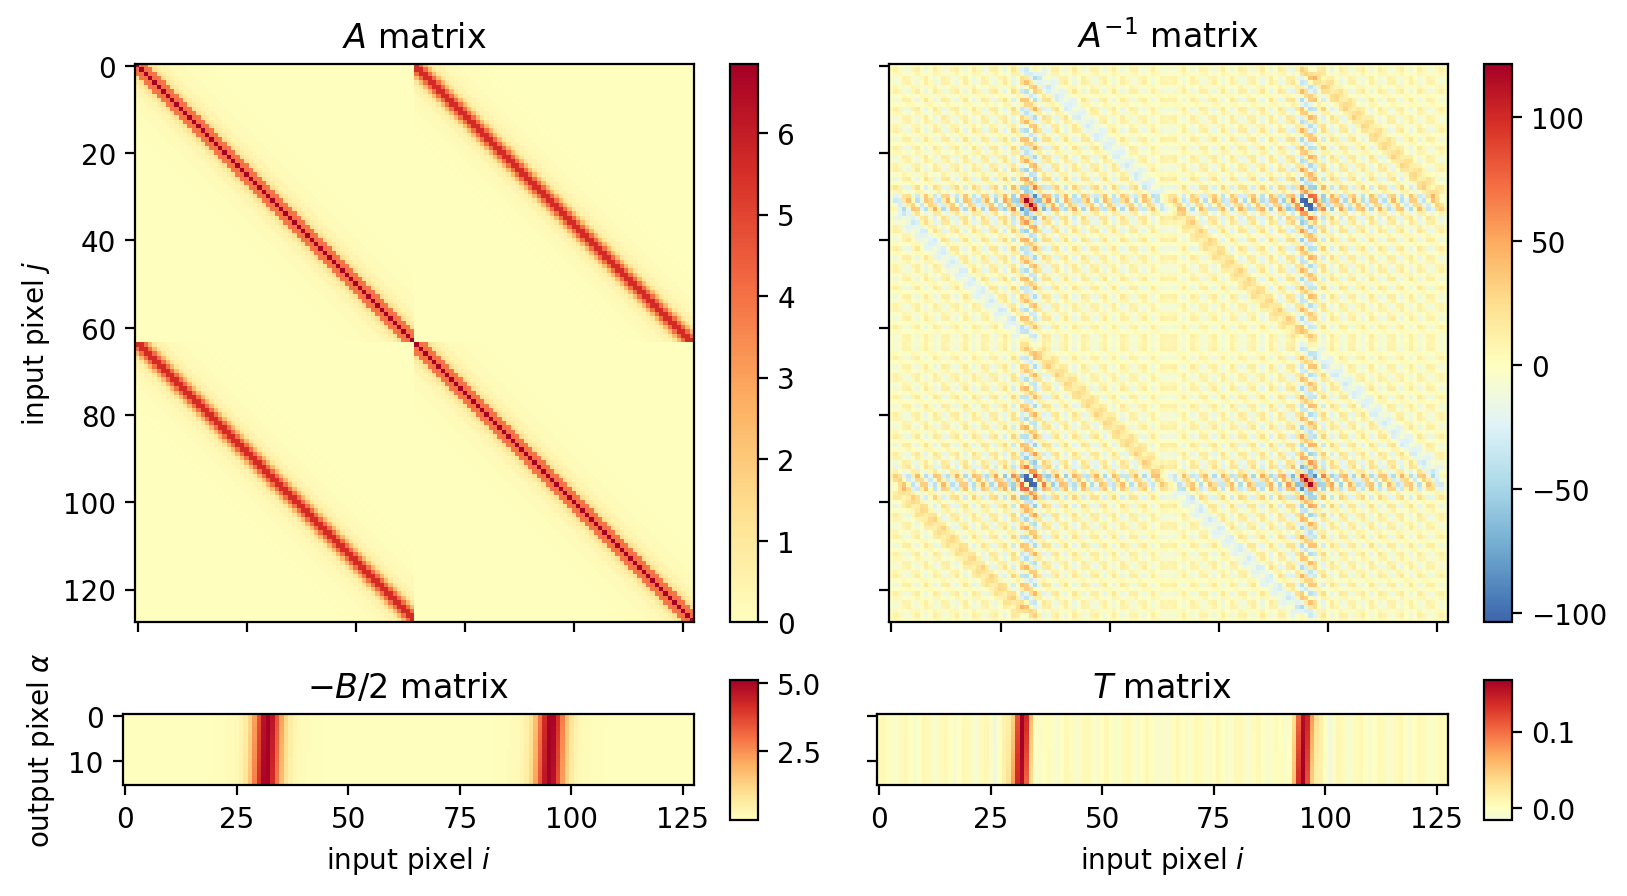

In [5]:
shifts = [0, 16]
Amat, Ainv, Bmat, Tmat = explore_case(ovl_ii, ovl_oi, shifts=shifts, aspect=5)

-3.1783268288343436e-06


/home/kailicao/fast_imcom_dev/psfutil_1d.py:125: RuntimeWarning: invalid value encountered in log10
  axs[1].plot(x, np.log10(psf))


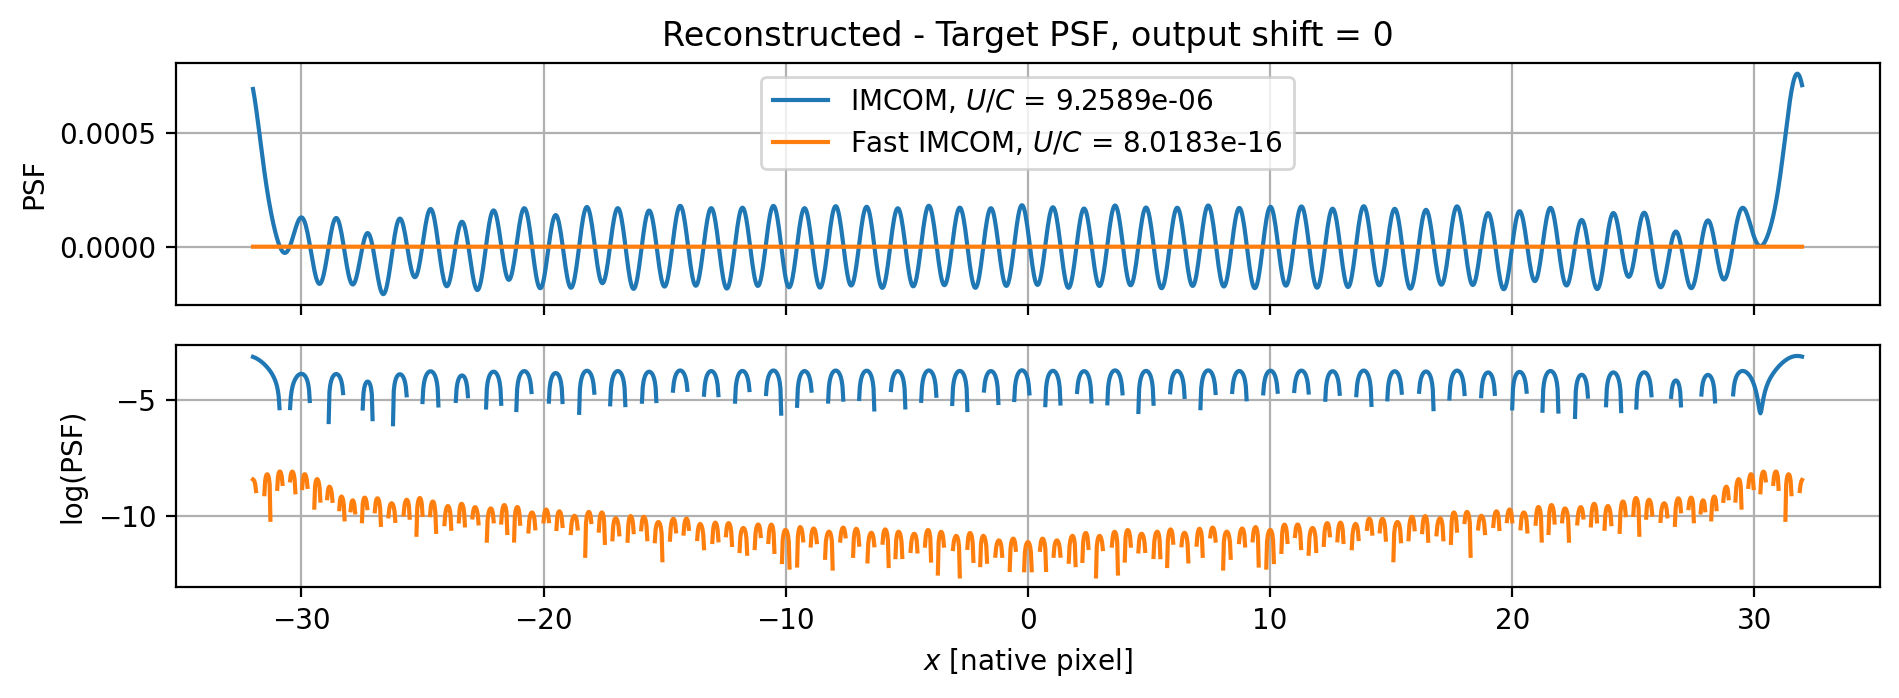

-3.1867228329485187e-06


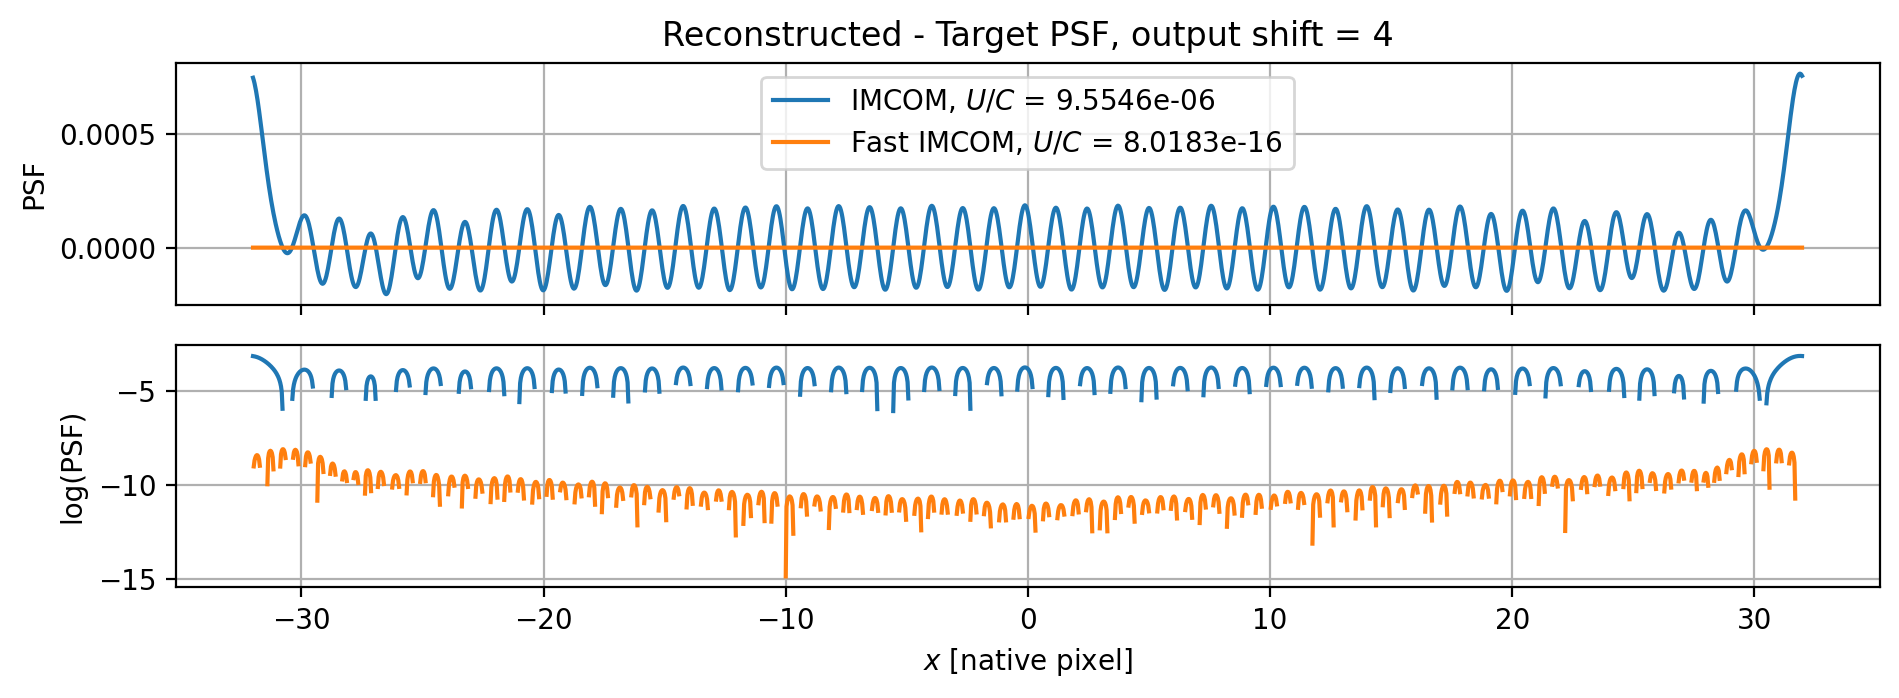

-3.1896706347289694e-06


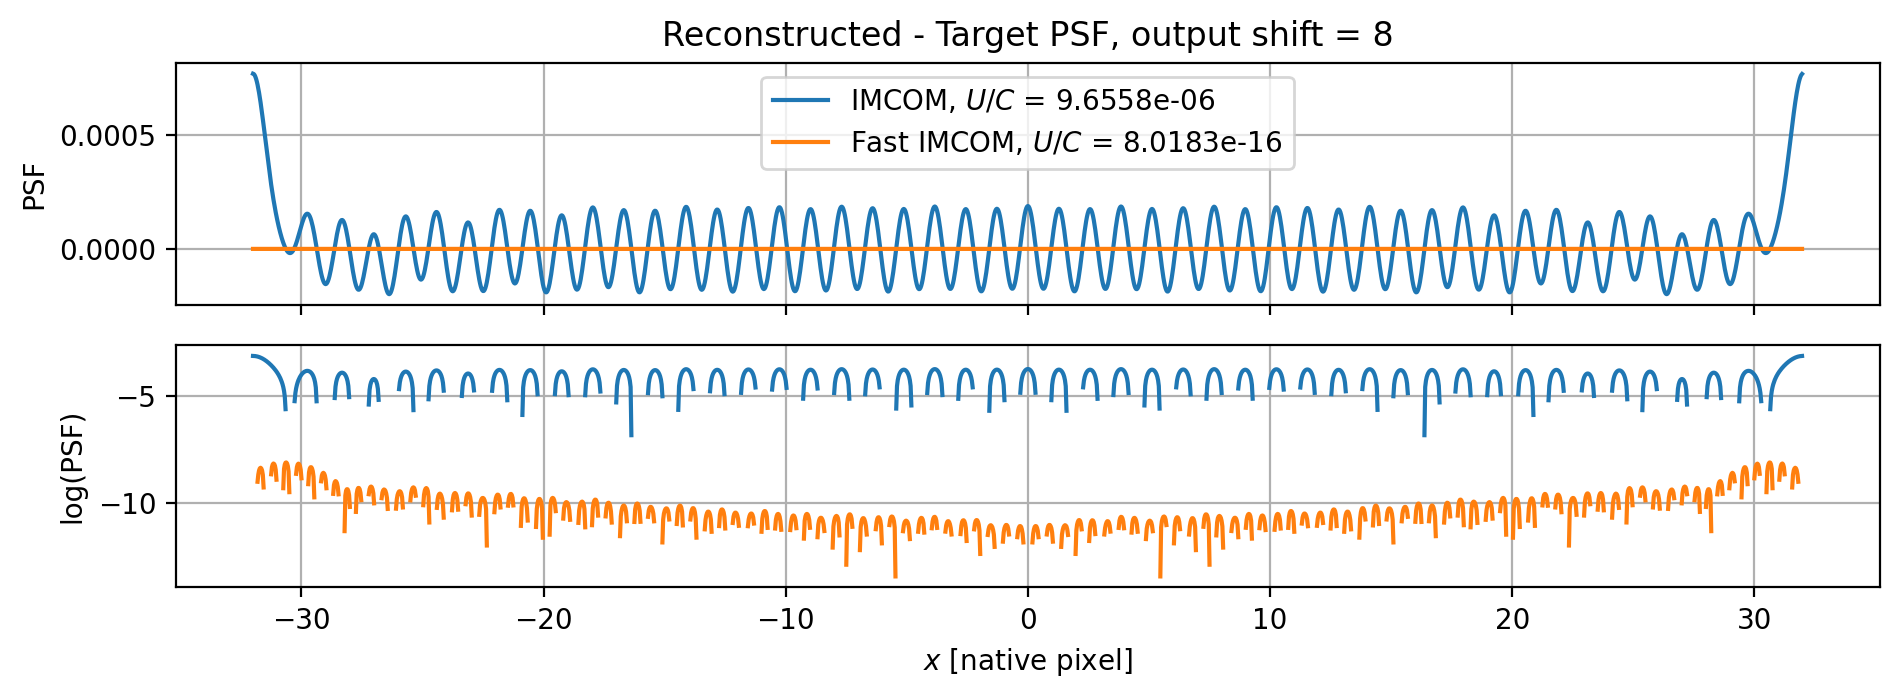

-3.186722839609857e-06


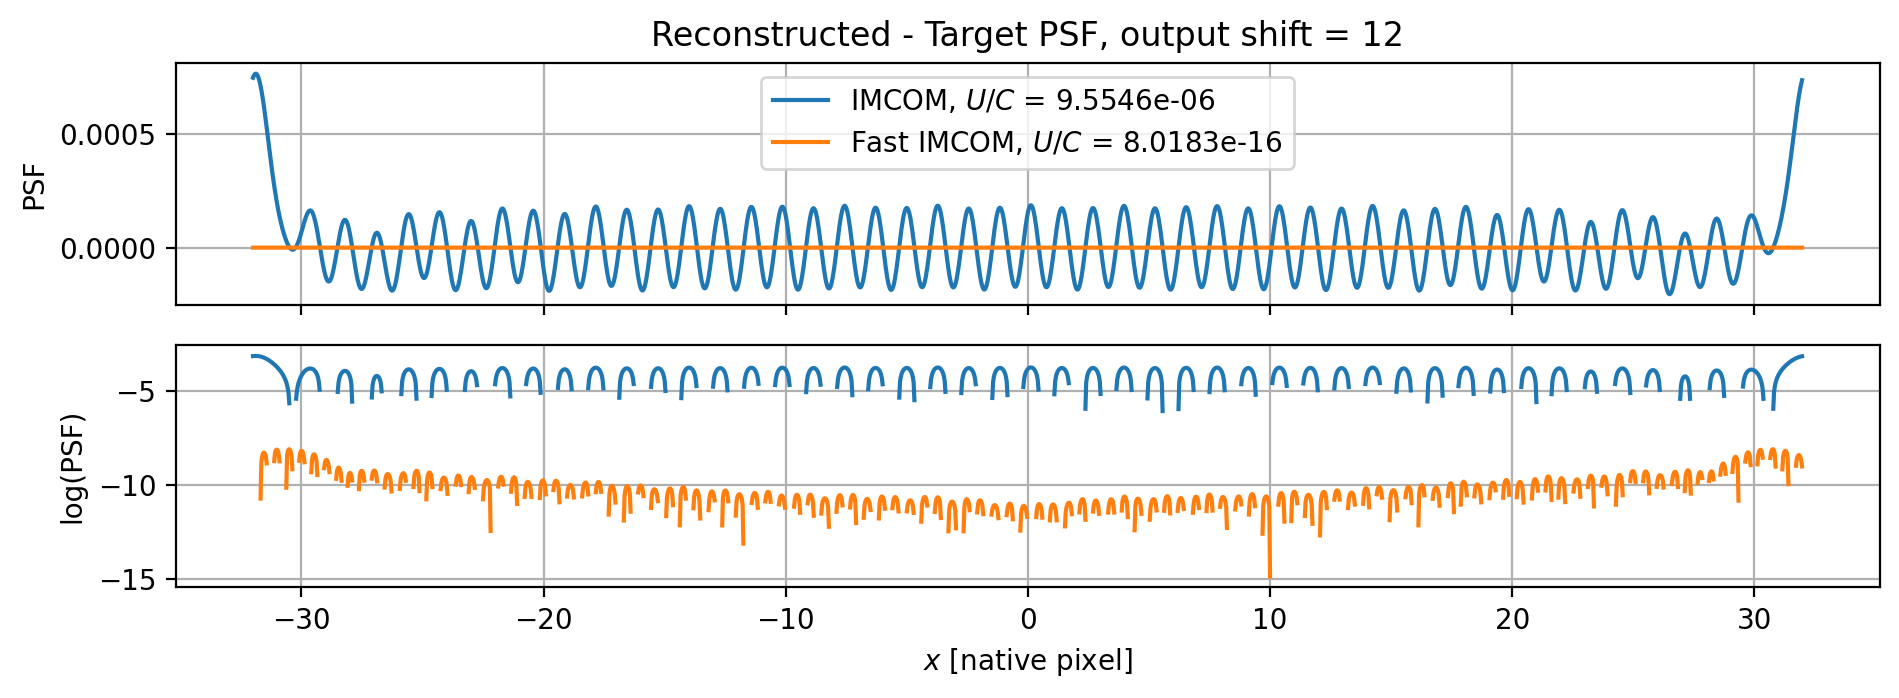

In [6]:
for shift in [0, 4, 8, 12]:  # Shift of the output pixel.
    my_weightu_i = np.zeros_like(weight)
    my_weightu_f = np.zeros_like(weight)
    for i, s in enumerate(shifts):  # Shifts of the input grids.
        my_weightu_i[s+shift::SAMP] = Tmat[shift, i*NPIX:(i+1)*NPIX]
        my_weightu_f[s+shift::SAMP] = weight[s+shift::SAMP] * SAMP / 2
    print(np.einsum("ji,j,i->", Amat, Tmat[shift], Tmat[shift]) / C\
        - 2 * np.einsum("j,j->", Bmat[shift], Tmat[shift]) / C + 1)

    visualize_case(my_weightu_i, my_weightu_f,
                   psf_inp_t, psf_out, f"output {shift = :d}")

5.596074895697356e-06


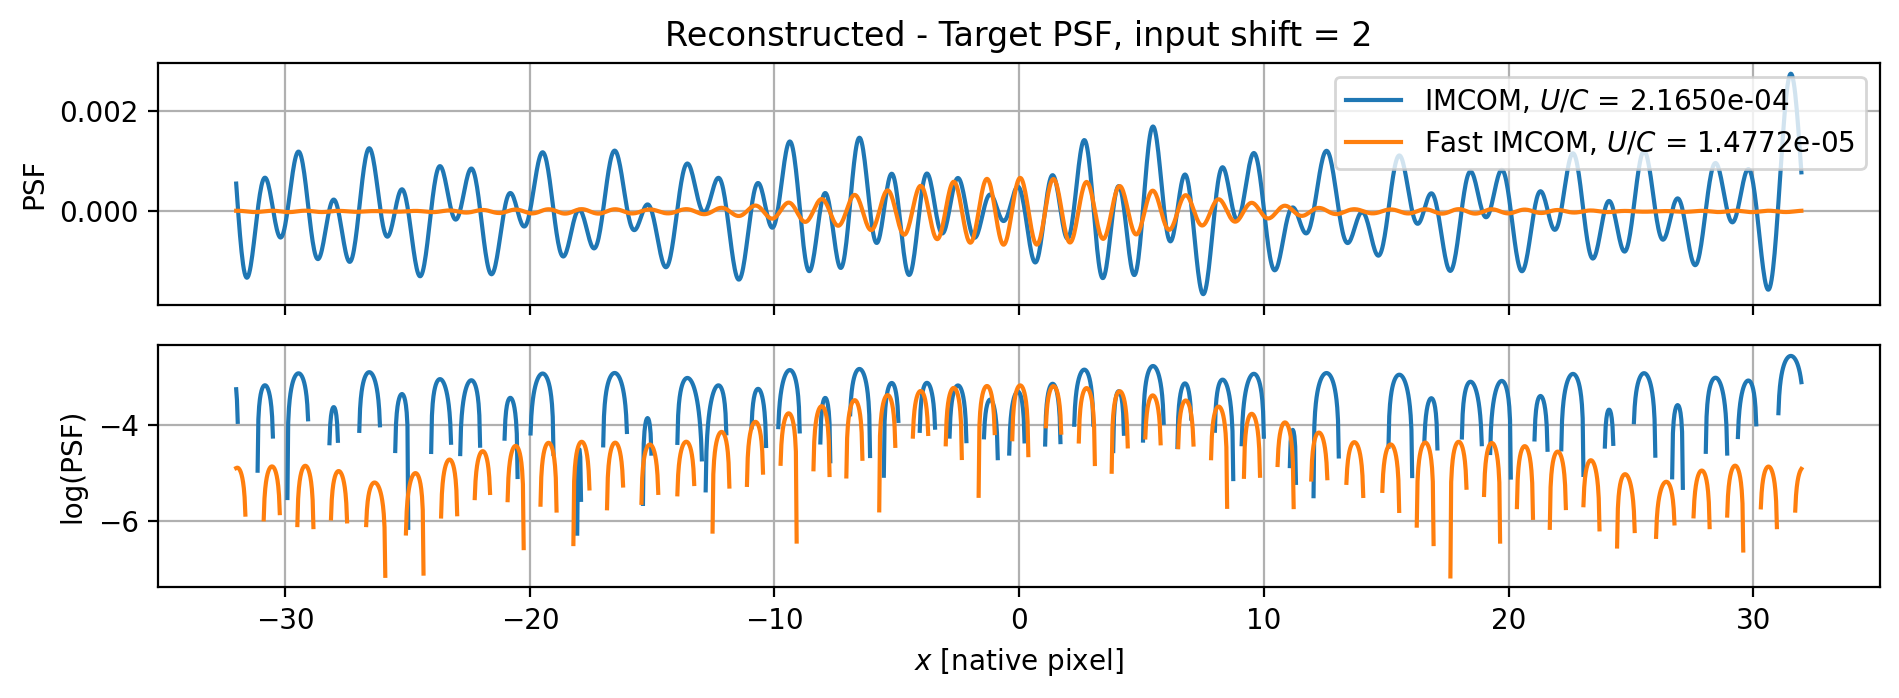

-0.0018924341418113944


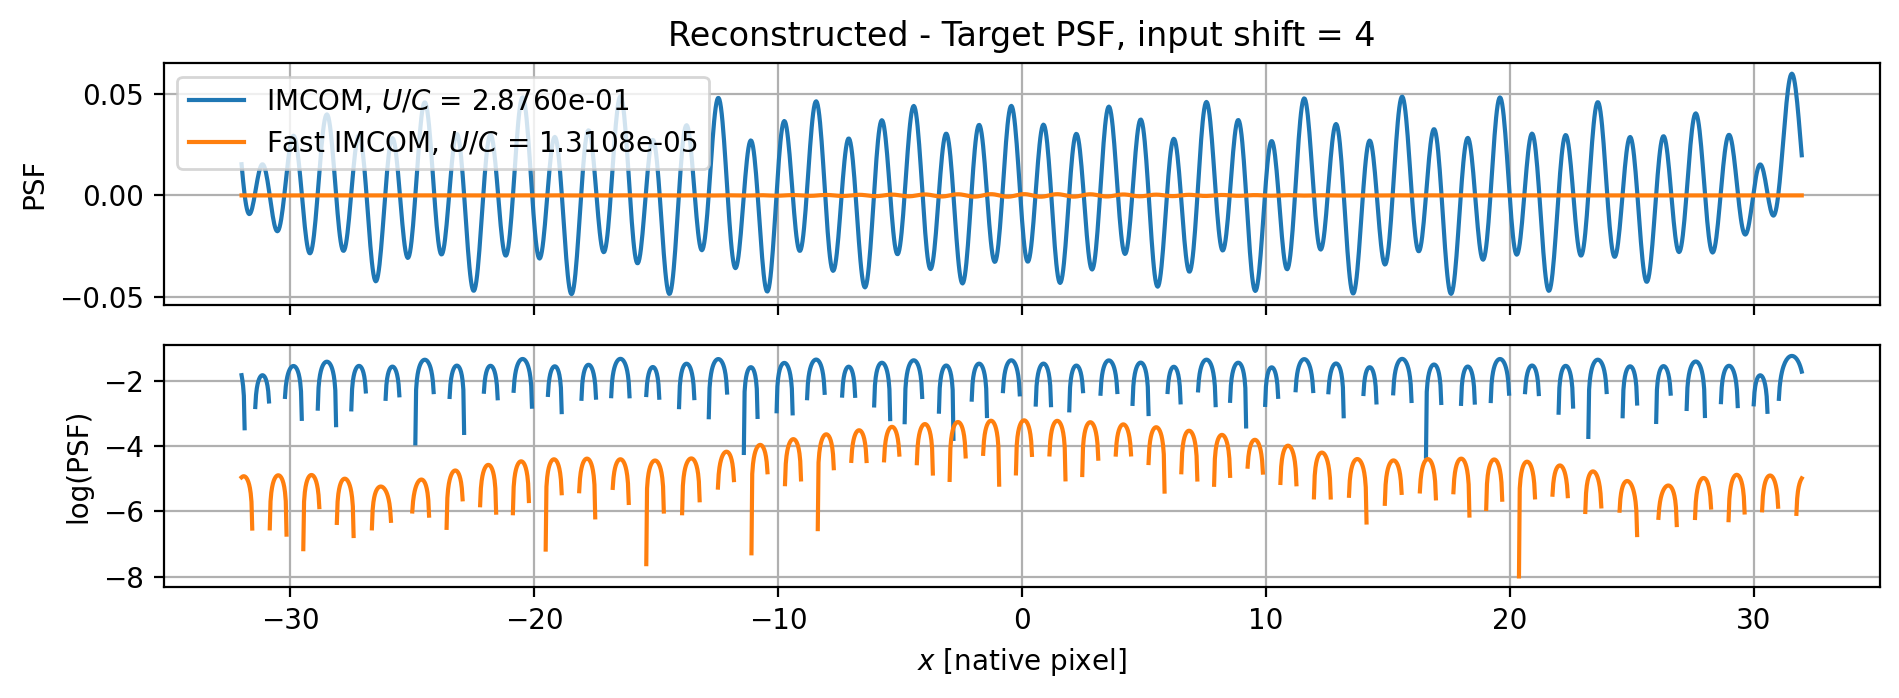

-1.4370558794274402e-05


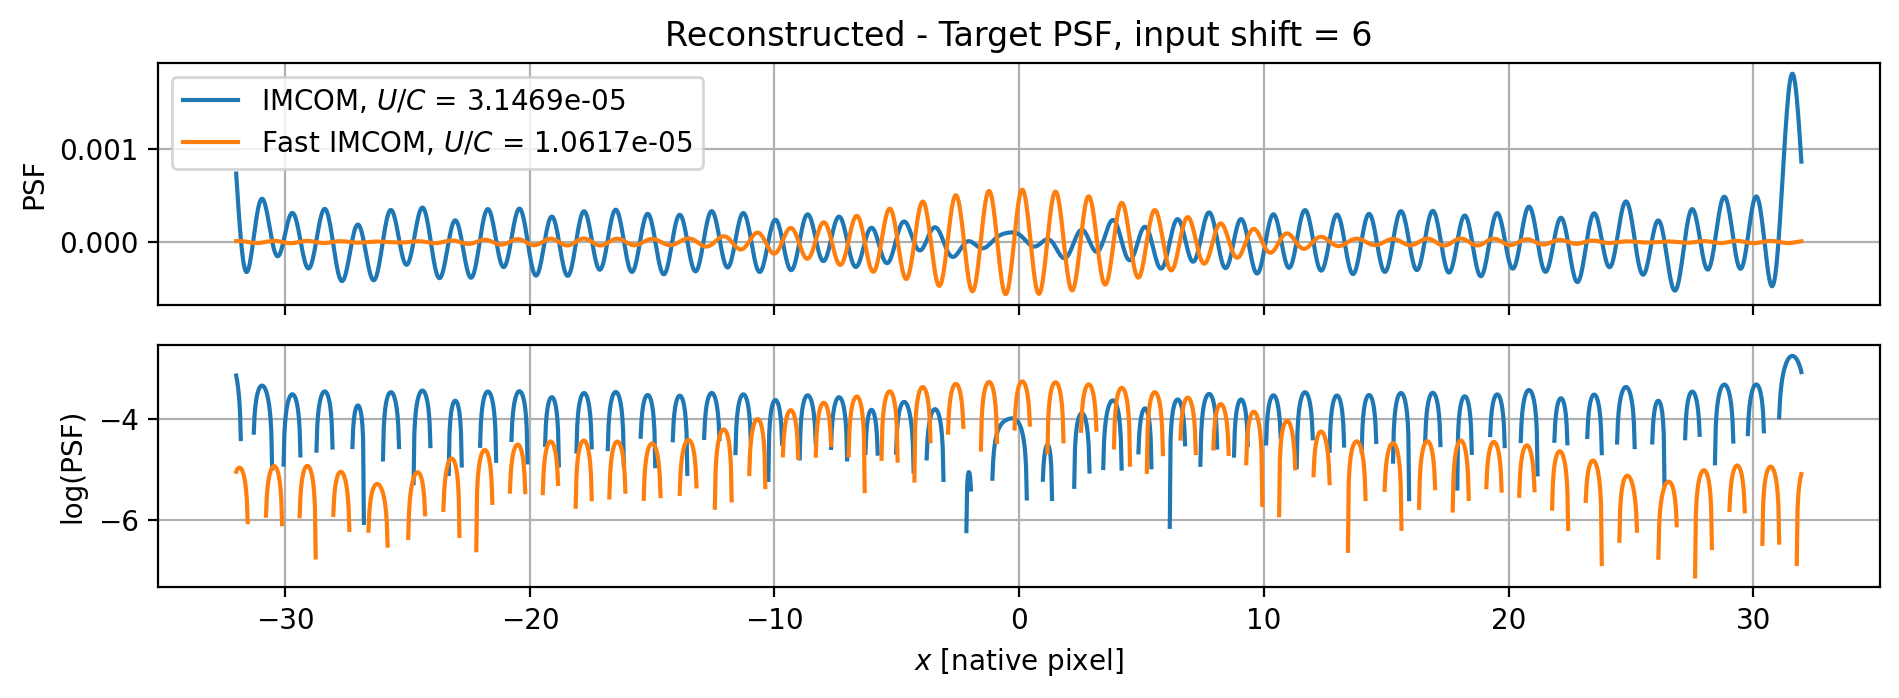

-3.5885862168516525e-06


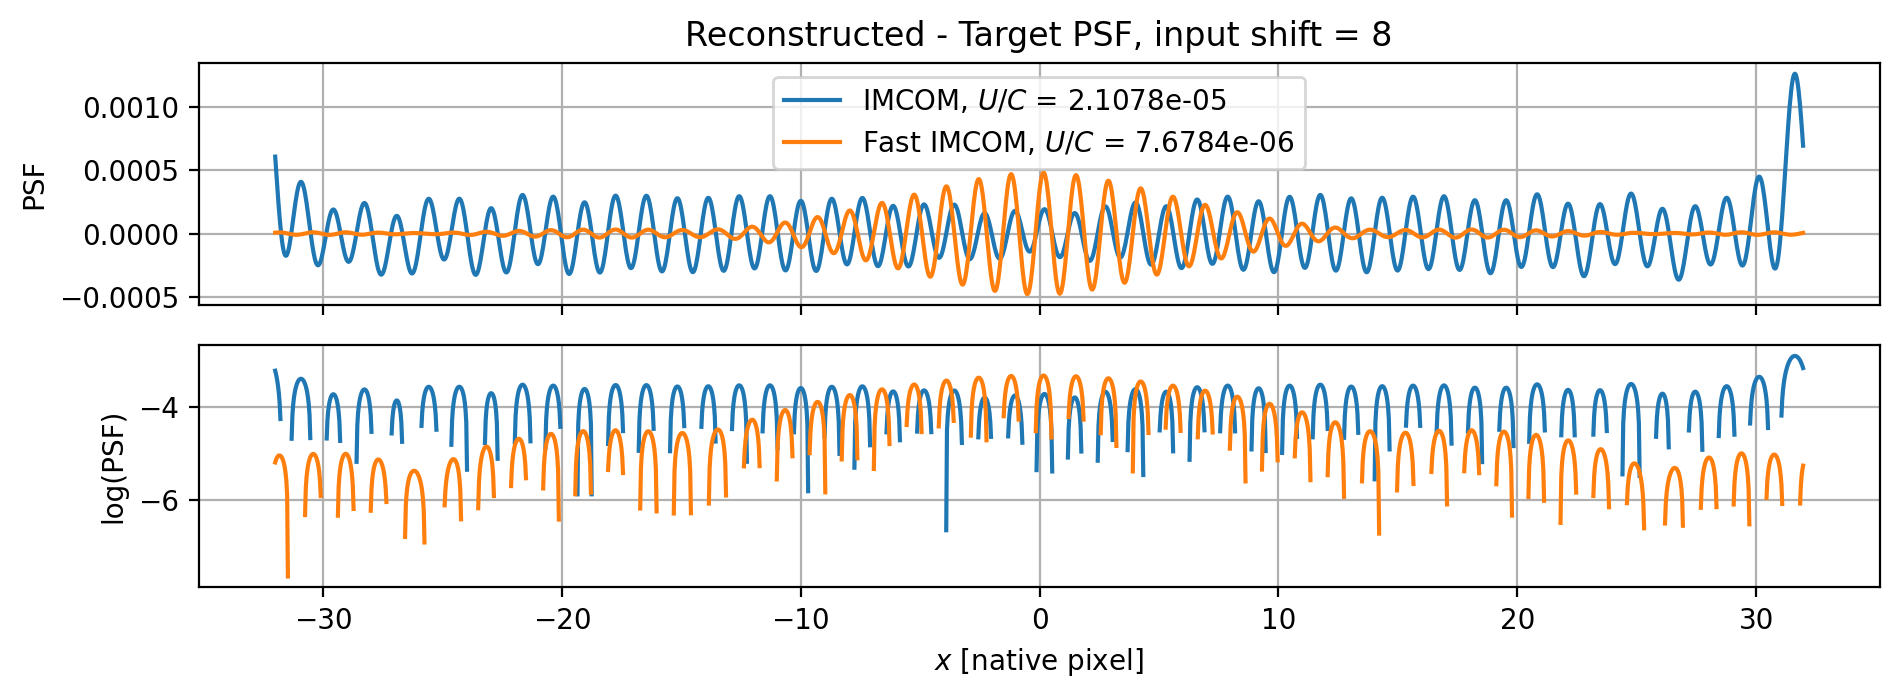

1.044472708644495e-05


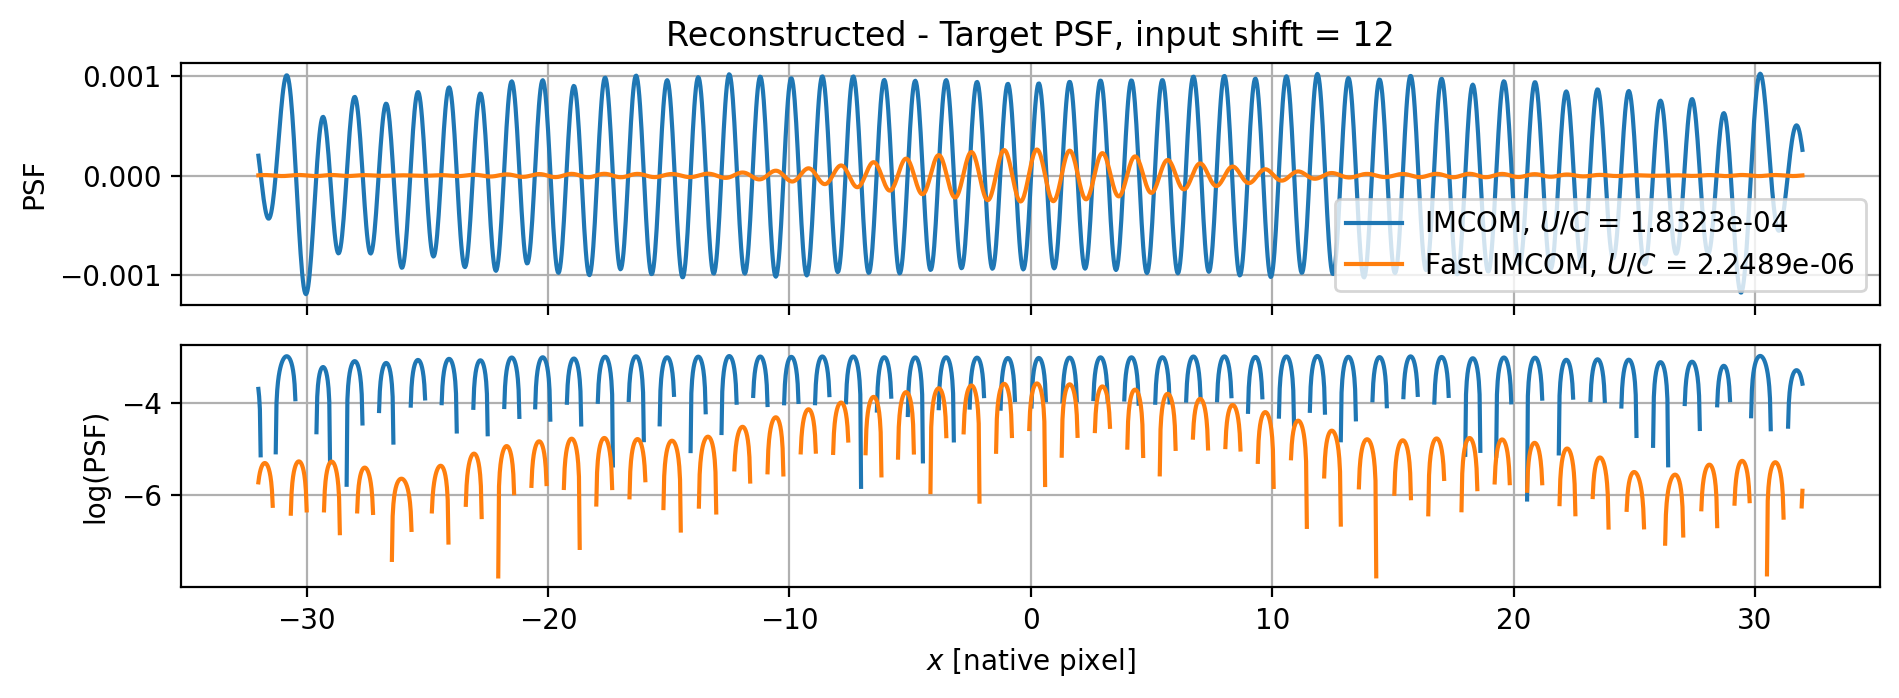

In [7]:
shift = 0  # Shift of the output pixel.
for s in [2, 4, 6, 8, 12]:
    shifts = [0, s]  # Shifts of the input grids.
    Amat, Ainv, Bmat, Tmat = explore_case(ovl_ii, ovl_oi, shifts=shifts)

    my_weightu_i = np.zeros_like(weight)
    my_weightu_f = np.zeros_like(weight)
    for i, s in enumerate(shifts):
        my_weightu_i[s+shift::SAMP] = Tmat[shift, i*NPIX:(i+1)*NPIX]
        my_weightu_f[s+shift::SAMP] = weight[s+shift::SAMP] * SAMP / 2
    print(np.einsum("ji,j,i->", Amat, Tmat[shift], Tmat[shift]) / C\
        - 2 * np.einsum("j,j->", Bmat[shift], Tmat[shift]) / C + 1)

    visualize_case(my_weightu_i, my_weightu_f,
                   psf_inp_t, psf_out, f"input shift = {s:d}")

1.213811623101968e-06


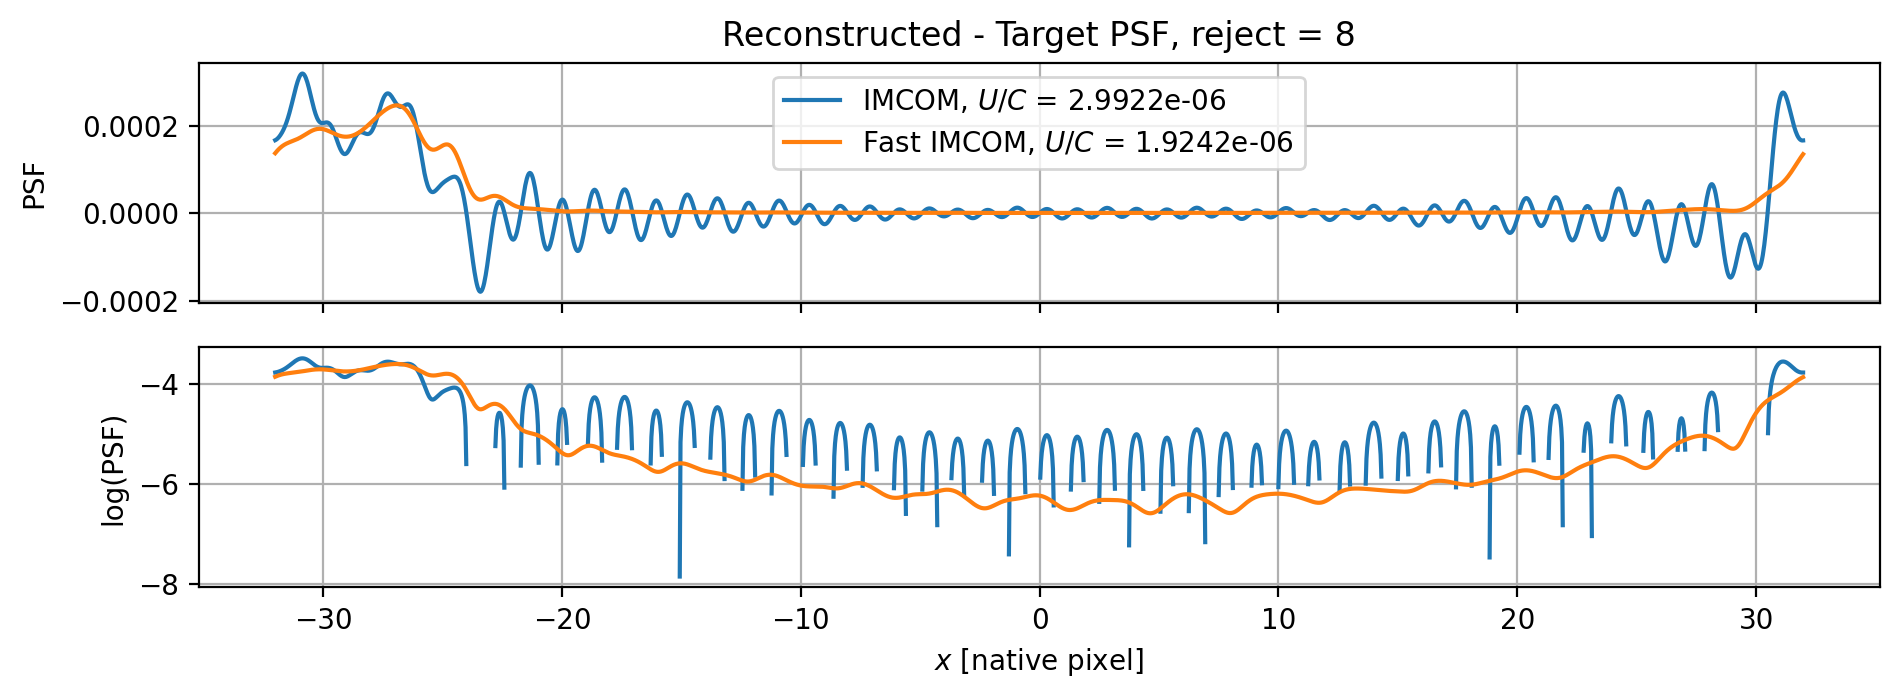

4.241863863829742e-06


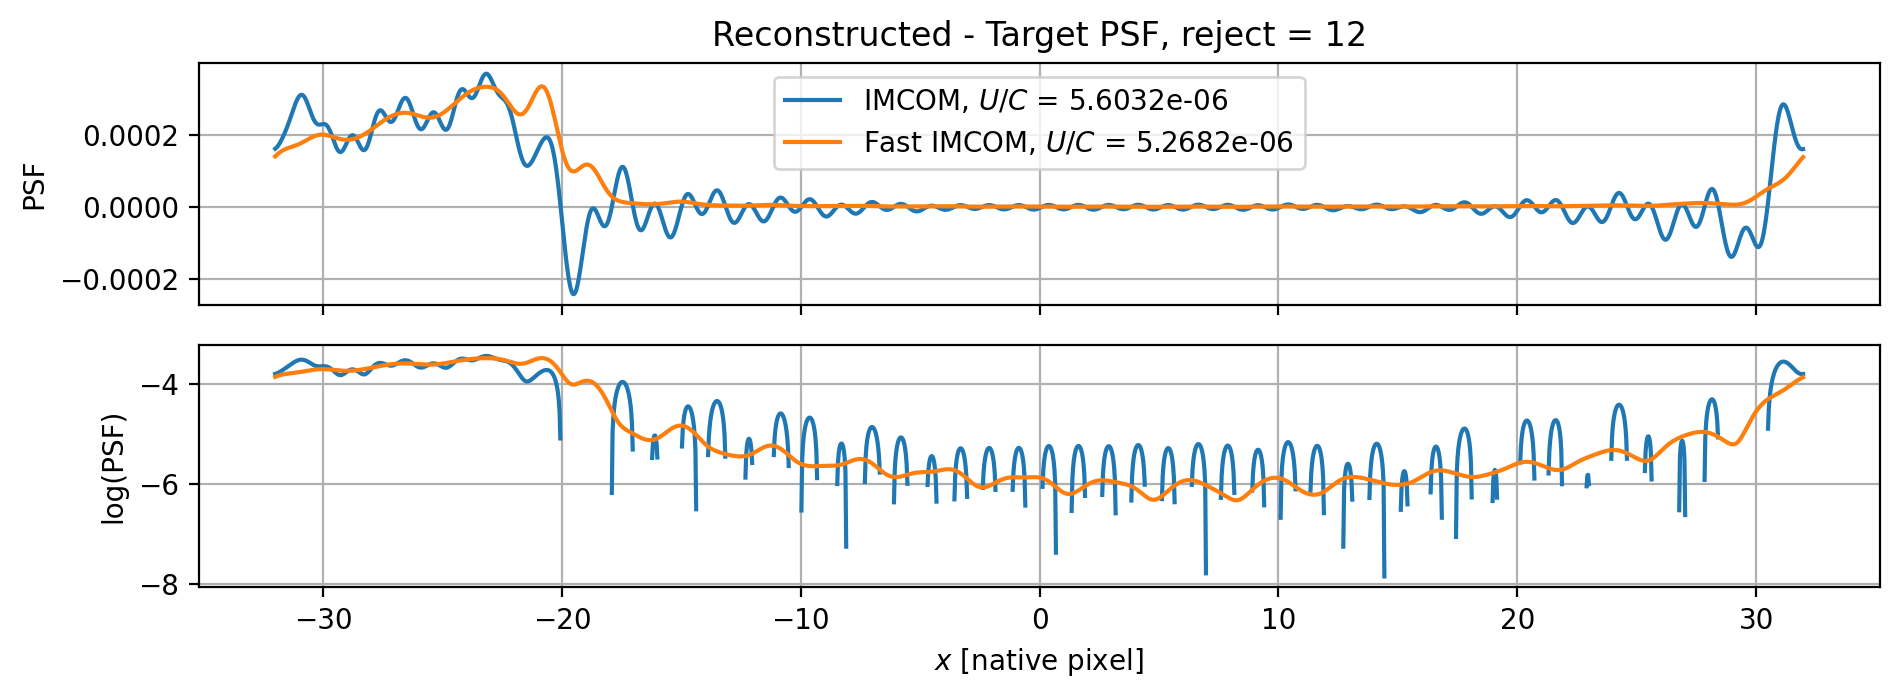

1.06782147556439e-05


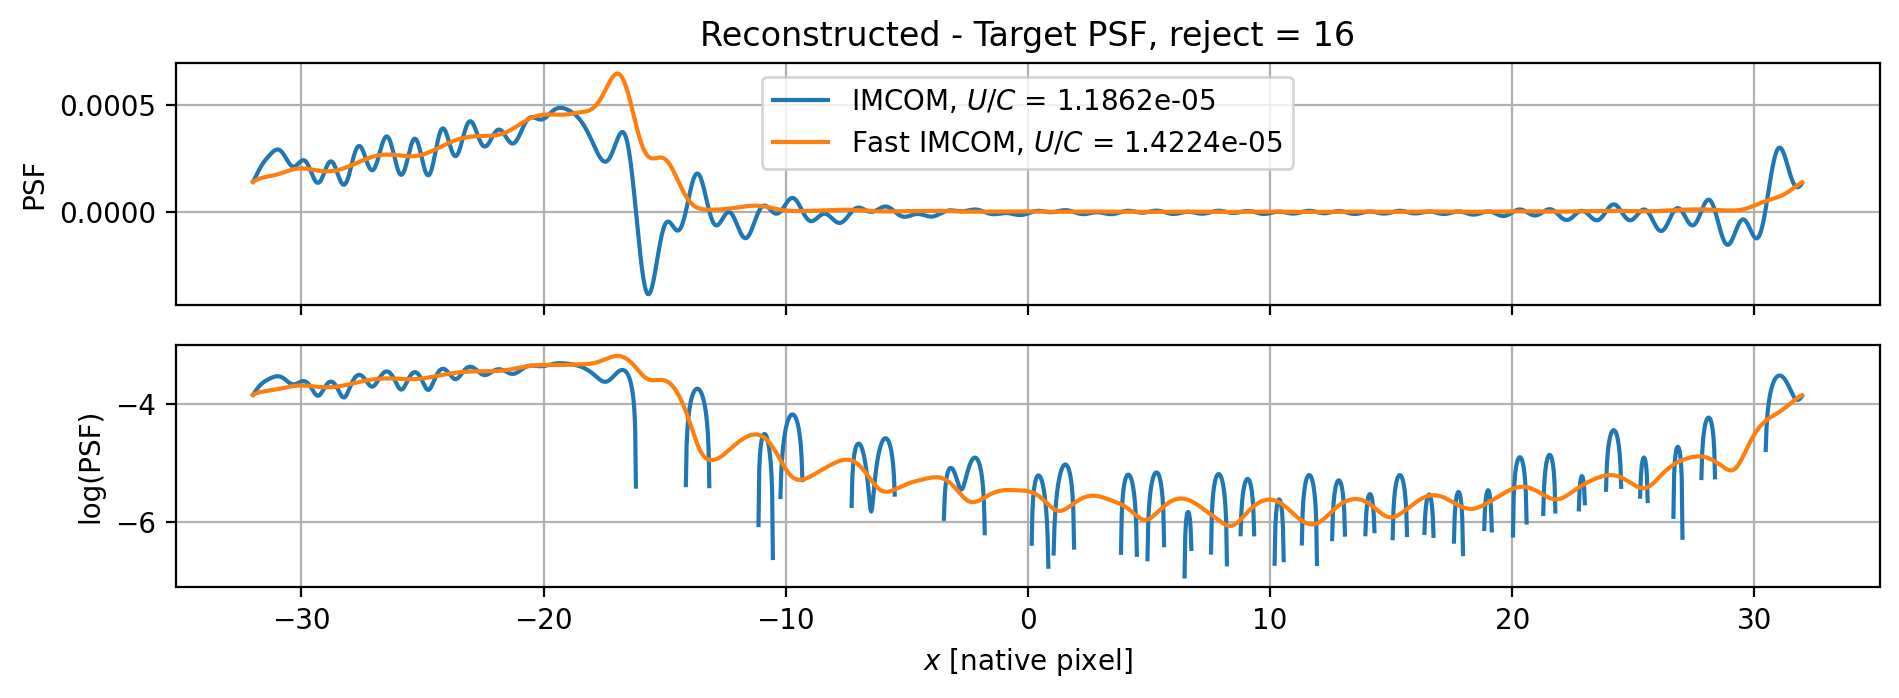

2.7208013175572532e-05


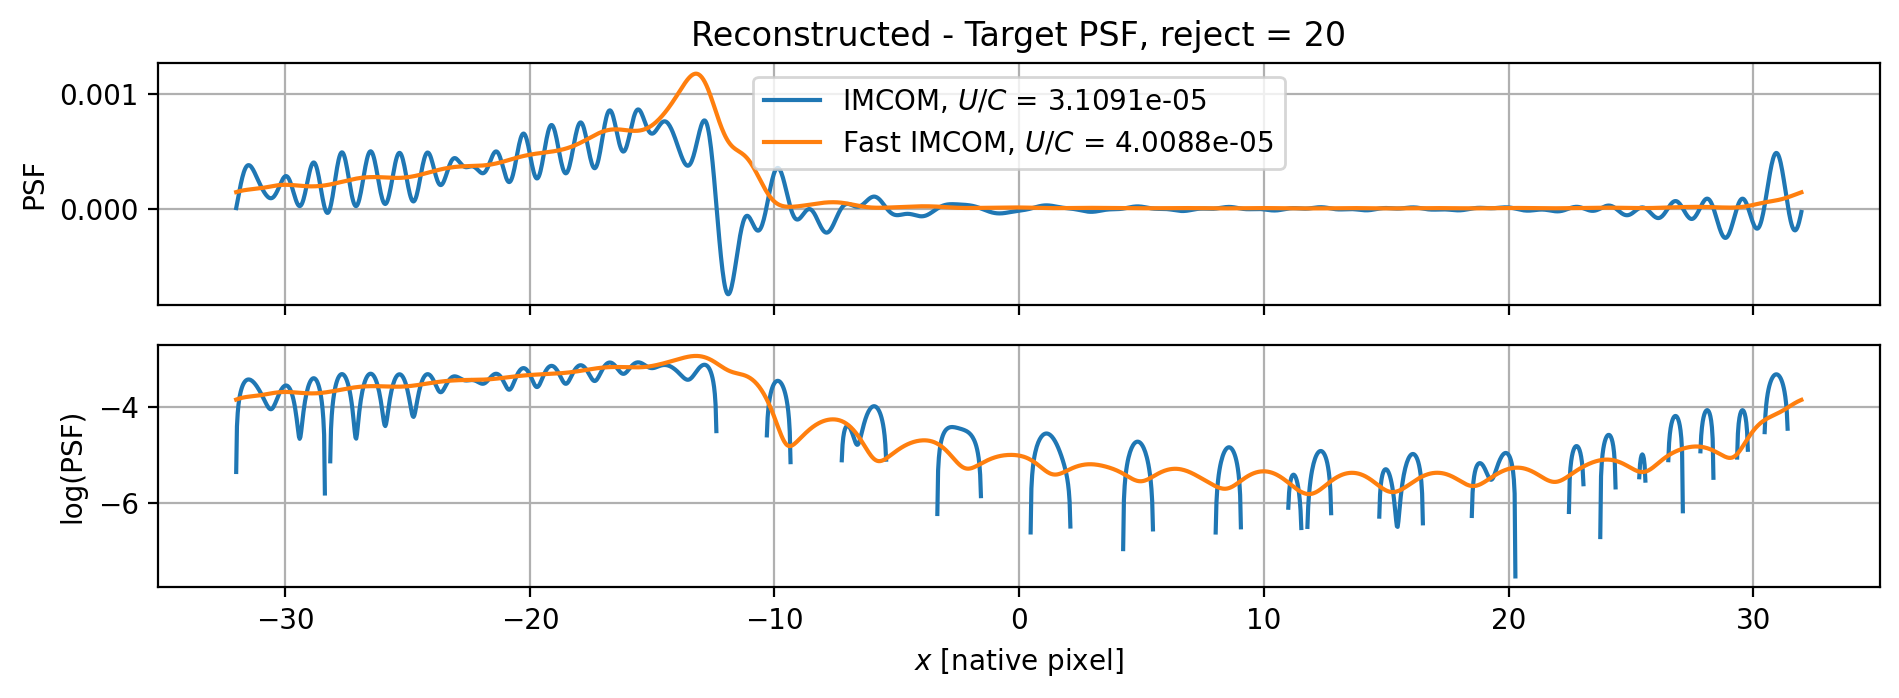

8.906406701980618e-05


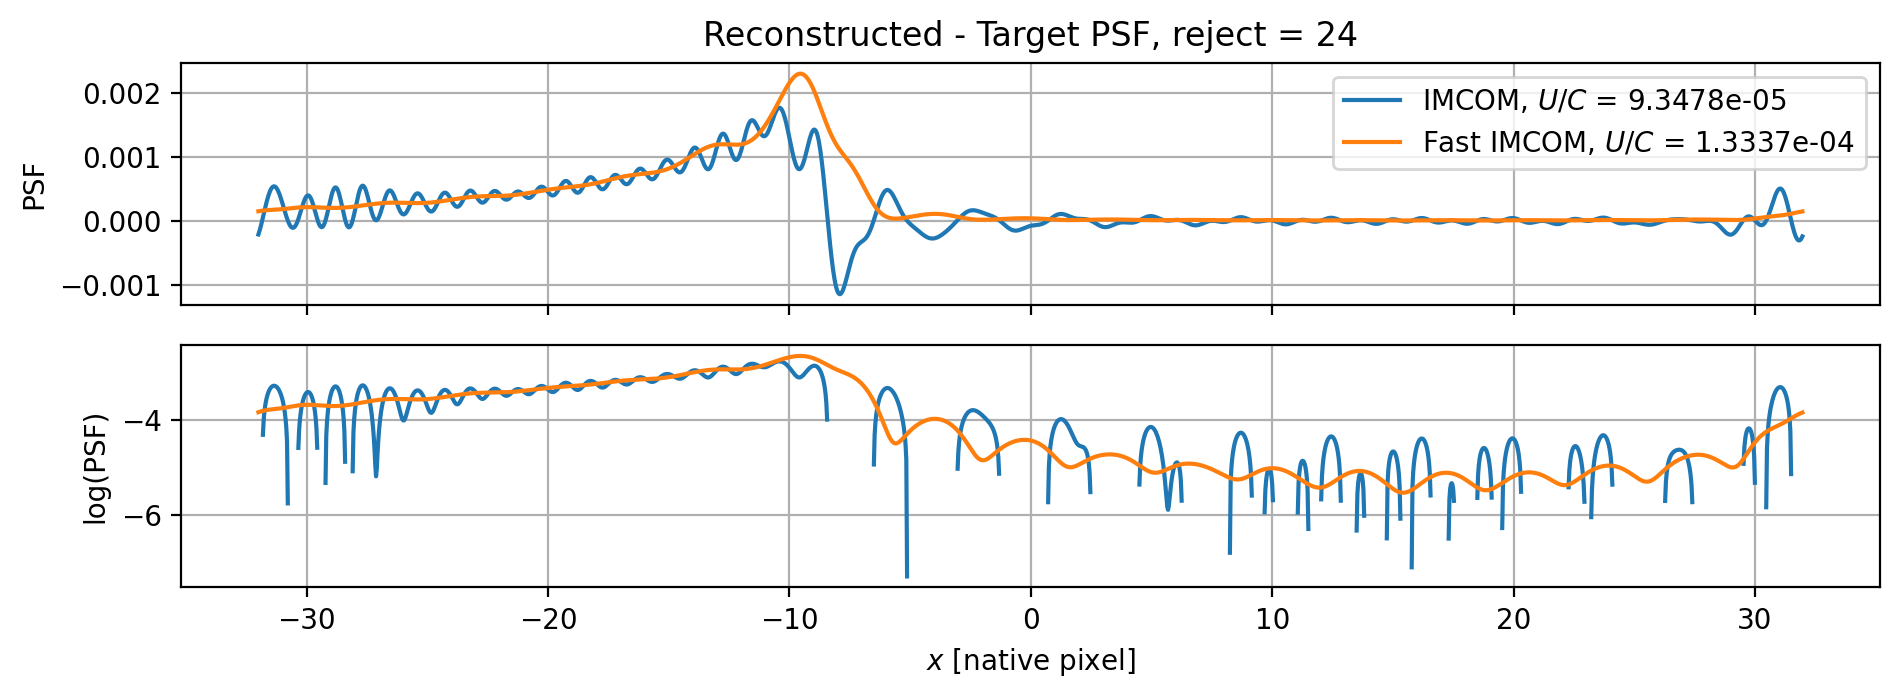

In [8]:
shift = 0  # Shift of the output pixel.
shifts = [0, 16]  # Shifts of the input grids.
for reject in [8, 12, 16, 20, 24]:
    Amat, Ainv, Bmat, Tmat = explore_case(
        ovl_ii, ovl_oi, shifts=shifts, reject=reject)
    npix = NPIX - reject

    my_weightu_i = np.zeros_like(weight)
    my_weightu_f = np.zeros_like(weight)
    for i, s in enumerate(shifts):
        my_weightu_i[reject*SAMP+s+shift::SAMP] = Tmat[shift, i*npix:(i+1)*npix]
        my_weightu_f[reject*SAMP+s+shift::SAMP] = weight[reject*SAMP+s+shift::SAMP] * SAMP / 2
    print(np.einsum("ji,j,i->", Amat, Tmat[shift], Tmat[shift]) / C\
        - 2 * np.einsum("j,j->", Bmat[shift], Tmat[shift]) / C + 1)

    visualize_case(my_weightu_i, my_weightu_f,
                   psf_inp_t, psf_out, f"{reject = :d}")

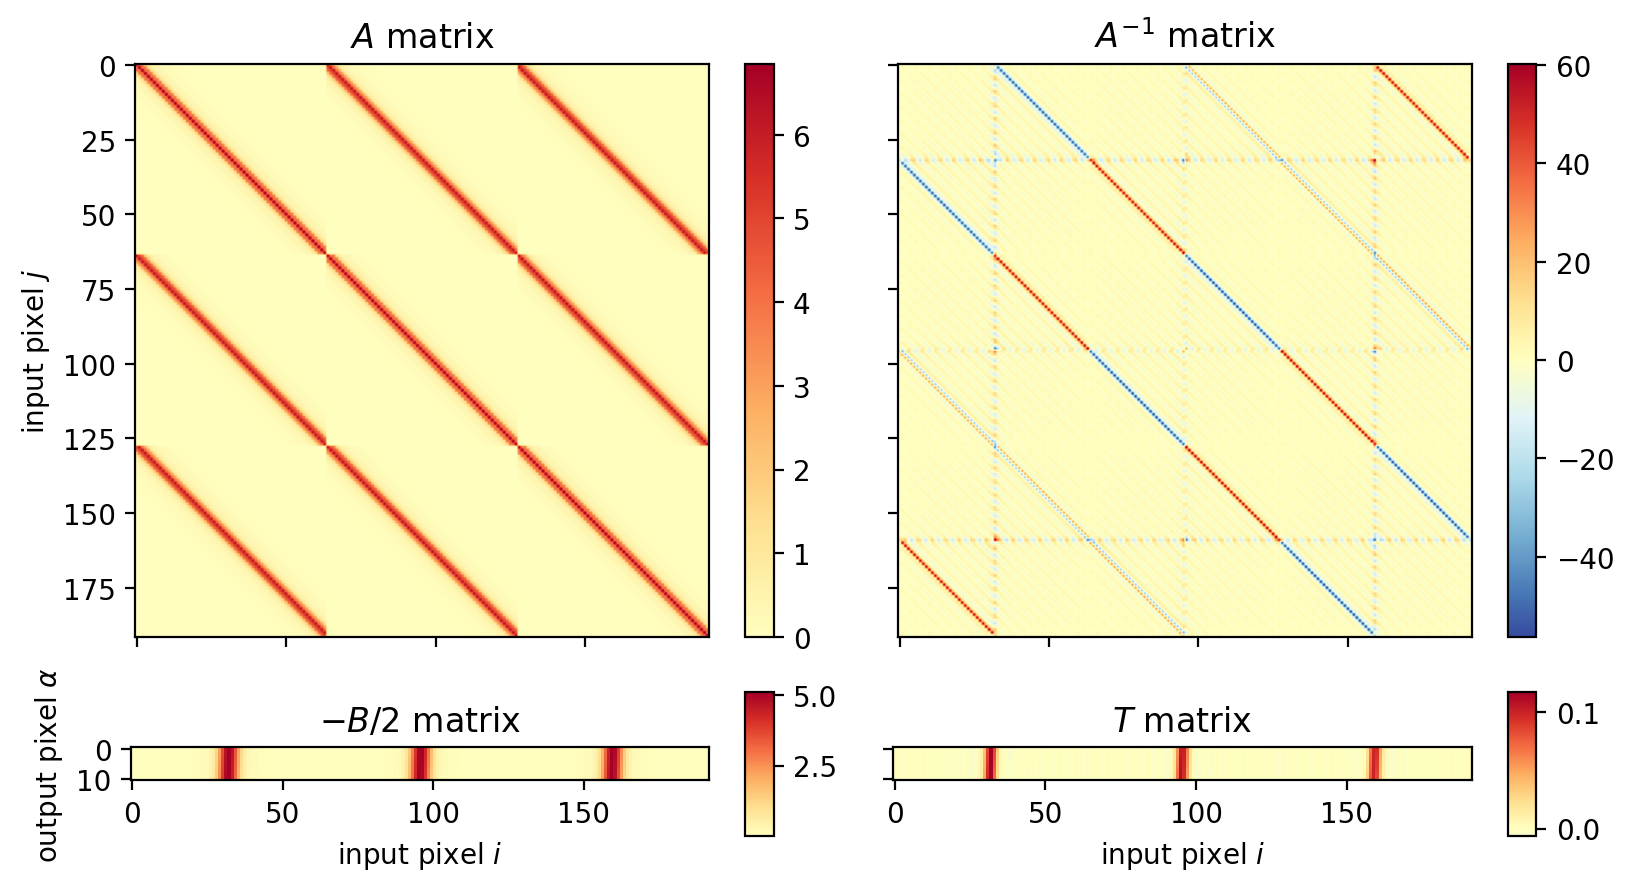

In [9]:
shifts = [0, 11, 21]
Amat, Ainv, Bmat, Tmat = explore_case(ovl_ii, ovl_oi, shifts=shifts, aspect=5)

-2.944579980956874e-06


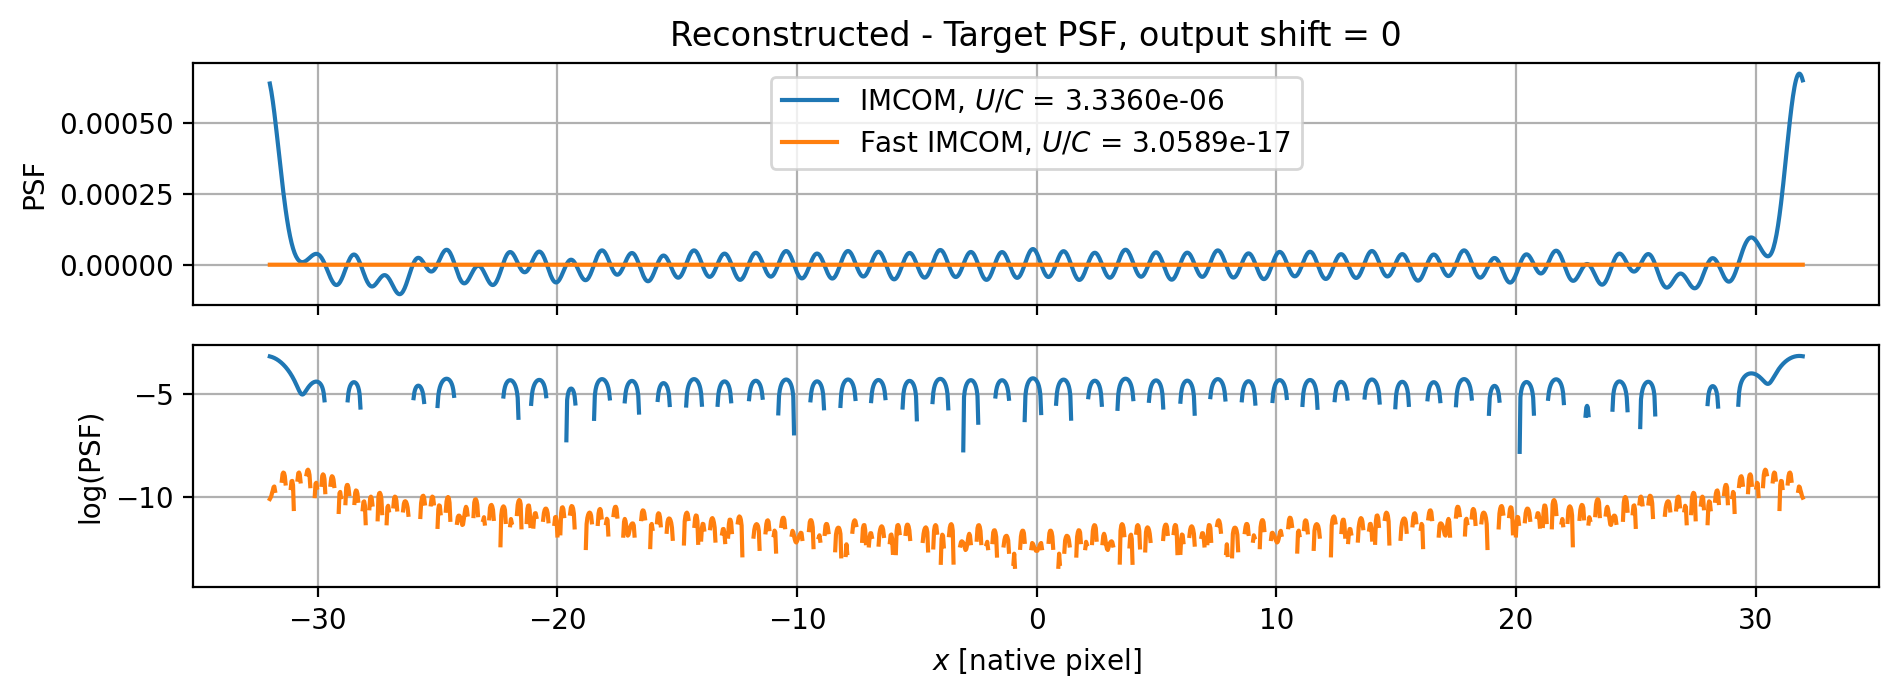

-2.935391401059917e-06


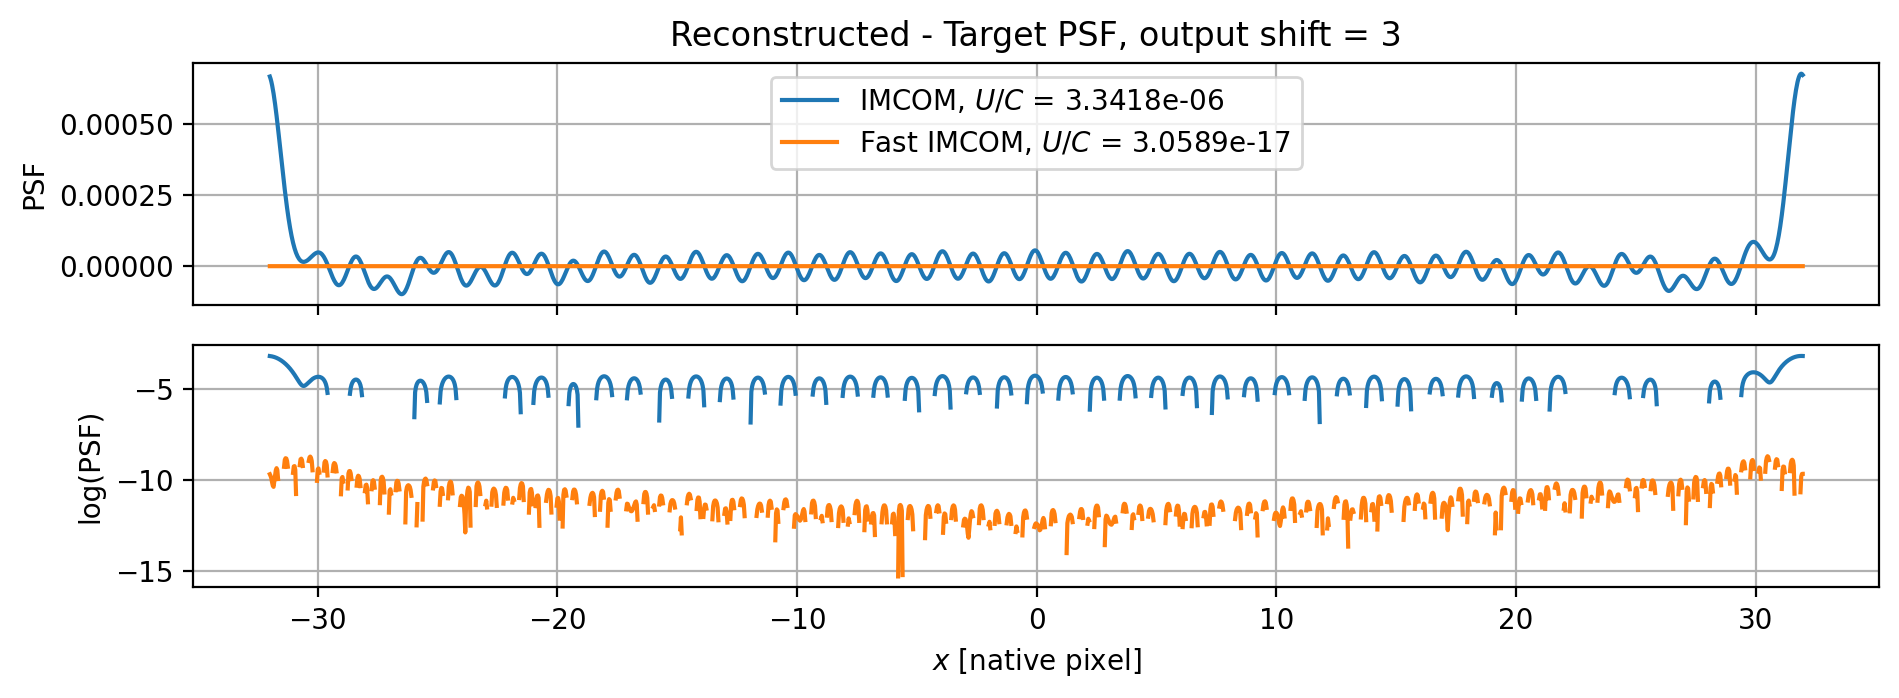

-2.925937318432048e-06


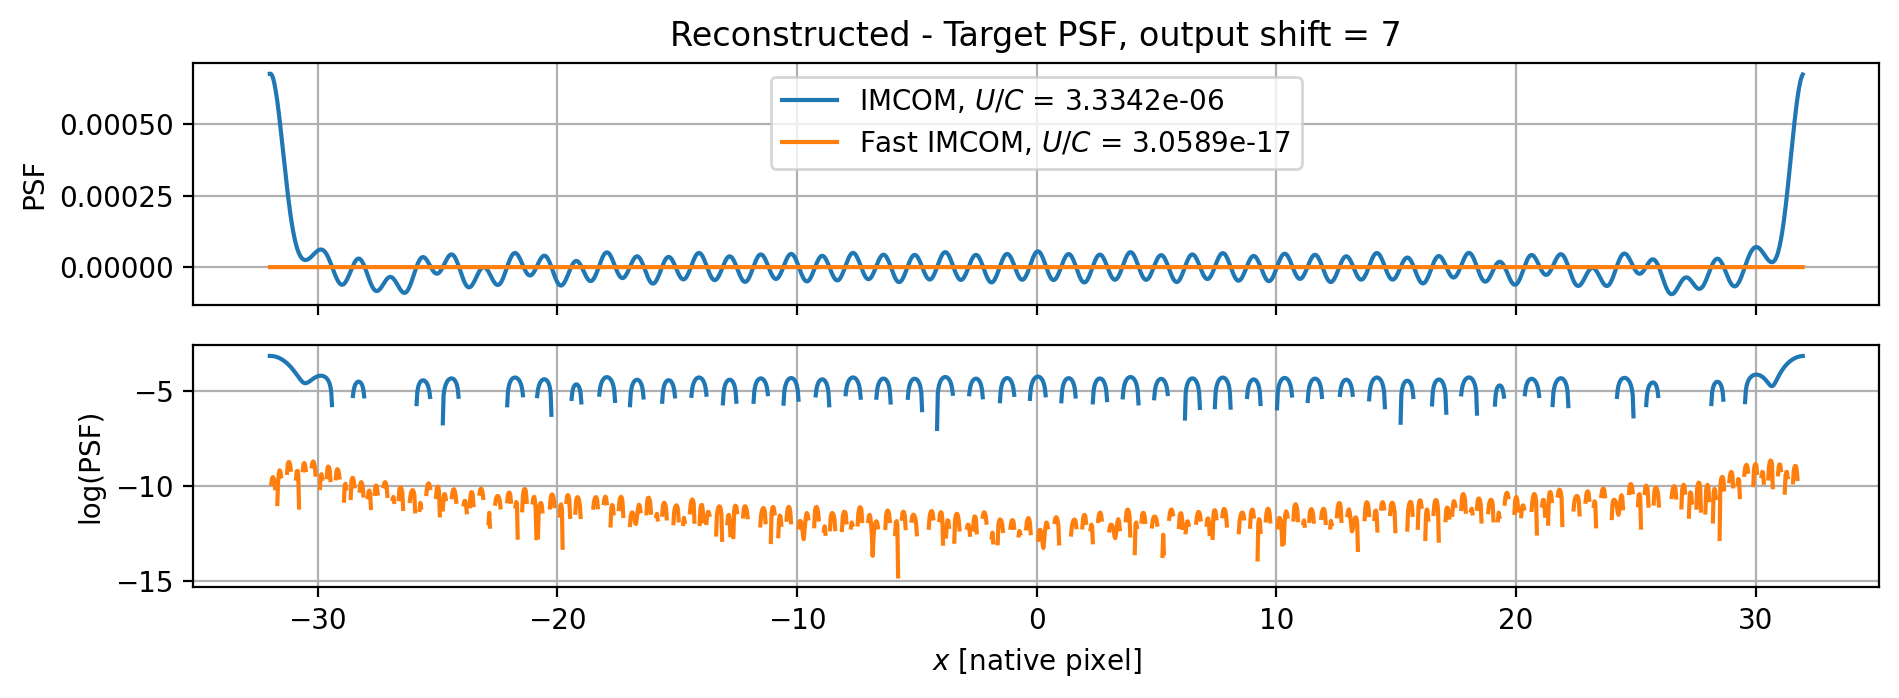

-2.921219659279828e-06


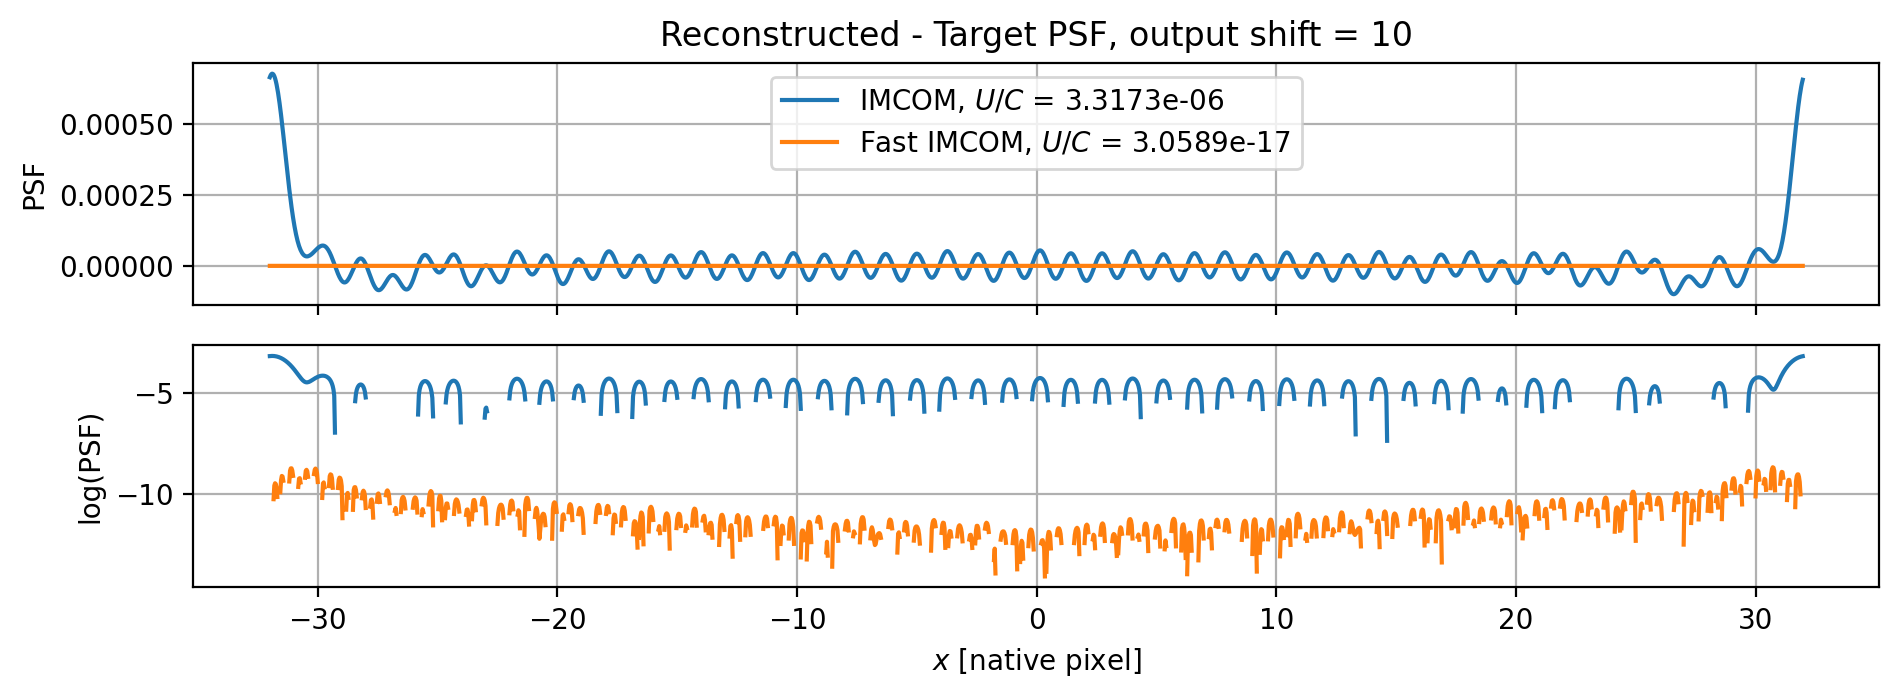

In [10]:
meta_weights = get_meta_weights(shifts)
for shift in [0, 3, 7, 10]:  # Shift of the output pixel.
    my_weightu_i = np.zeros_like(weight)
    my_weightu_f = np.zeros_like(weight)
    for i, s in enumerate(shifts):  # Shifts of the input grids.
        my_weightu_i[s+shift::SAMP] = Tmat[shift, i*NPIX:(i+1)*NPIX]
        my_weightu_f[s+shift::SAMP] = weight[s+shift::SAMP] * SAMP * meta_weights[i]
    print(np.einsum("ji,j,i->", Amat, Tmat[shift], Tmat[shift]) / C\
        - 2 * np.einsum("j,j->", Bmat[shift], Tmat[shift]) / C + 1)

    visualize_case(my_weightu_i, my_weightu_f,
                   psf_inp_t, psf_out, f"output {shift = :d}")

1.7355545174235765e-05


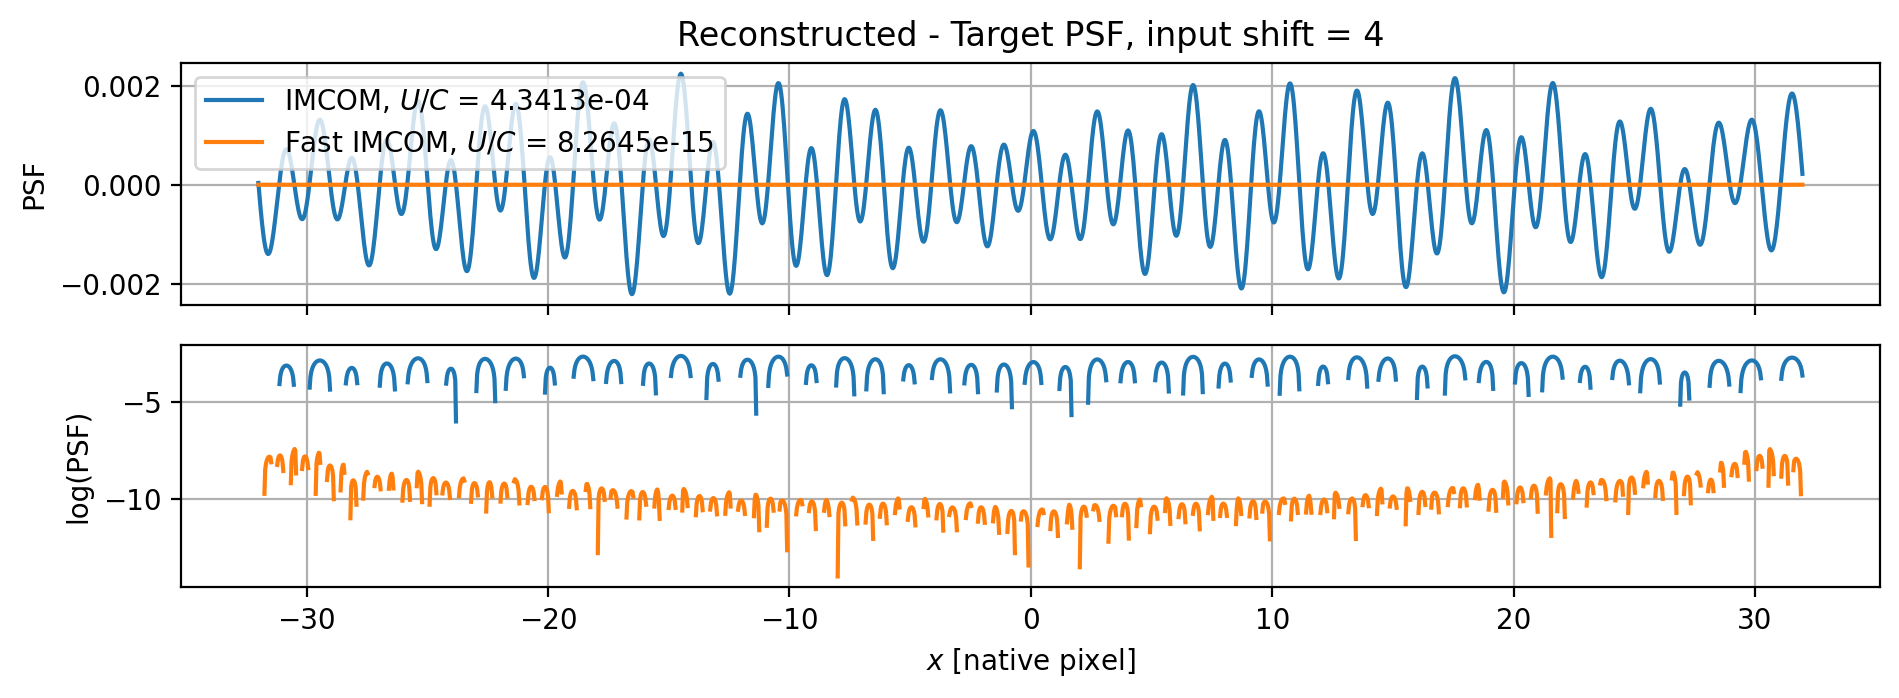

-9.154409569944733e-06


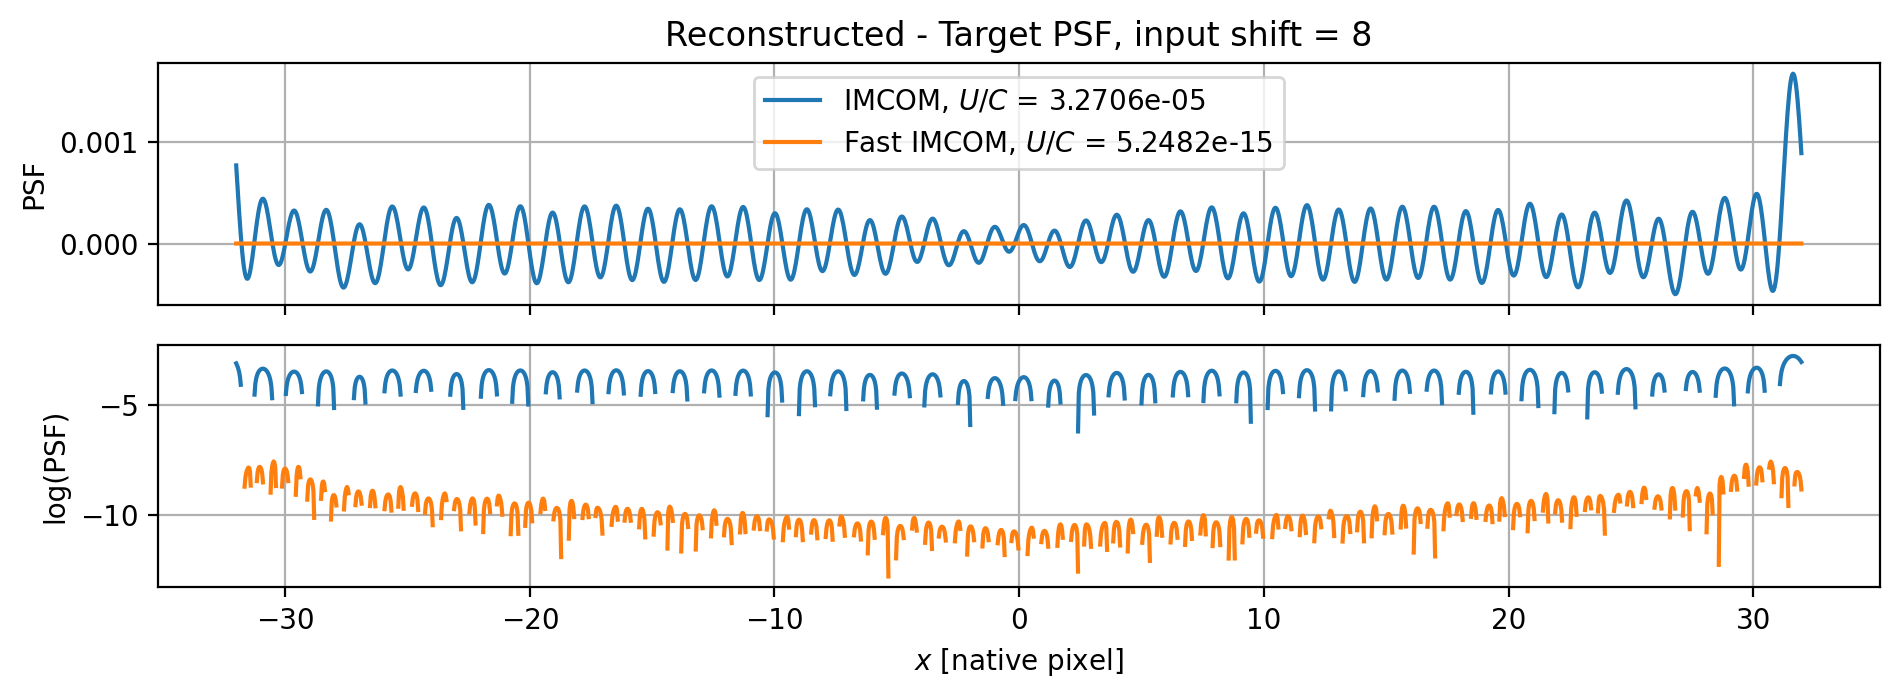

2.1447768849602866e-05


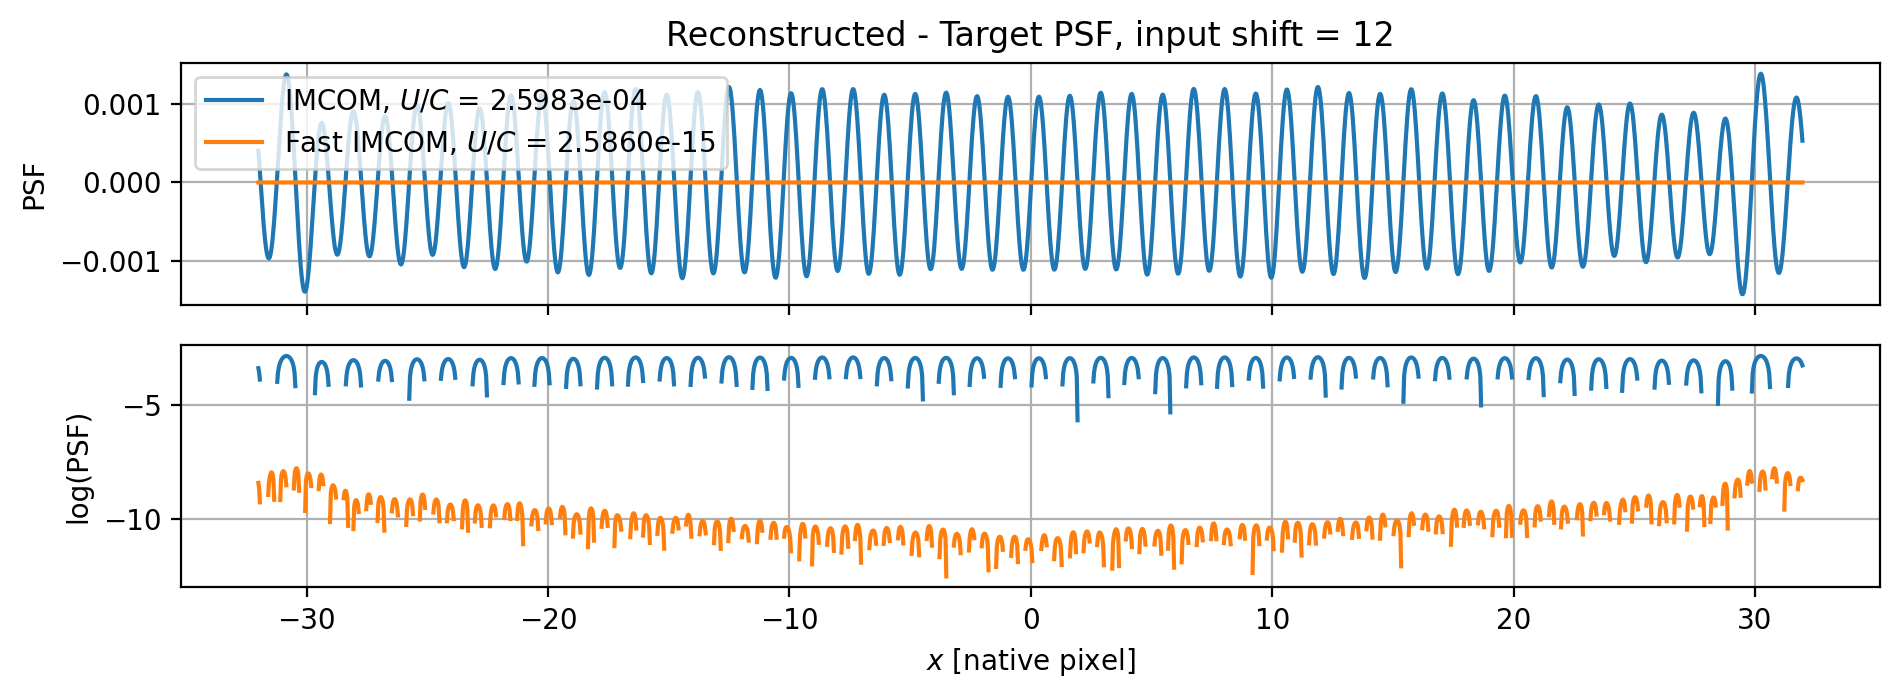

-8.599902908024148e-06


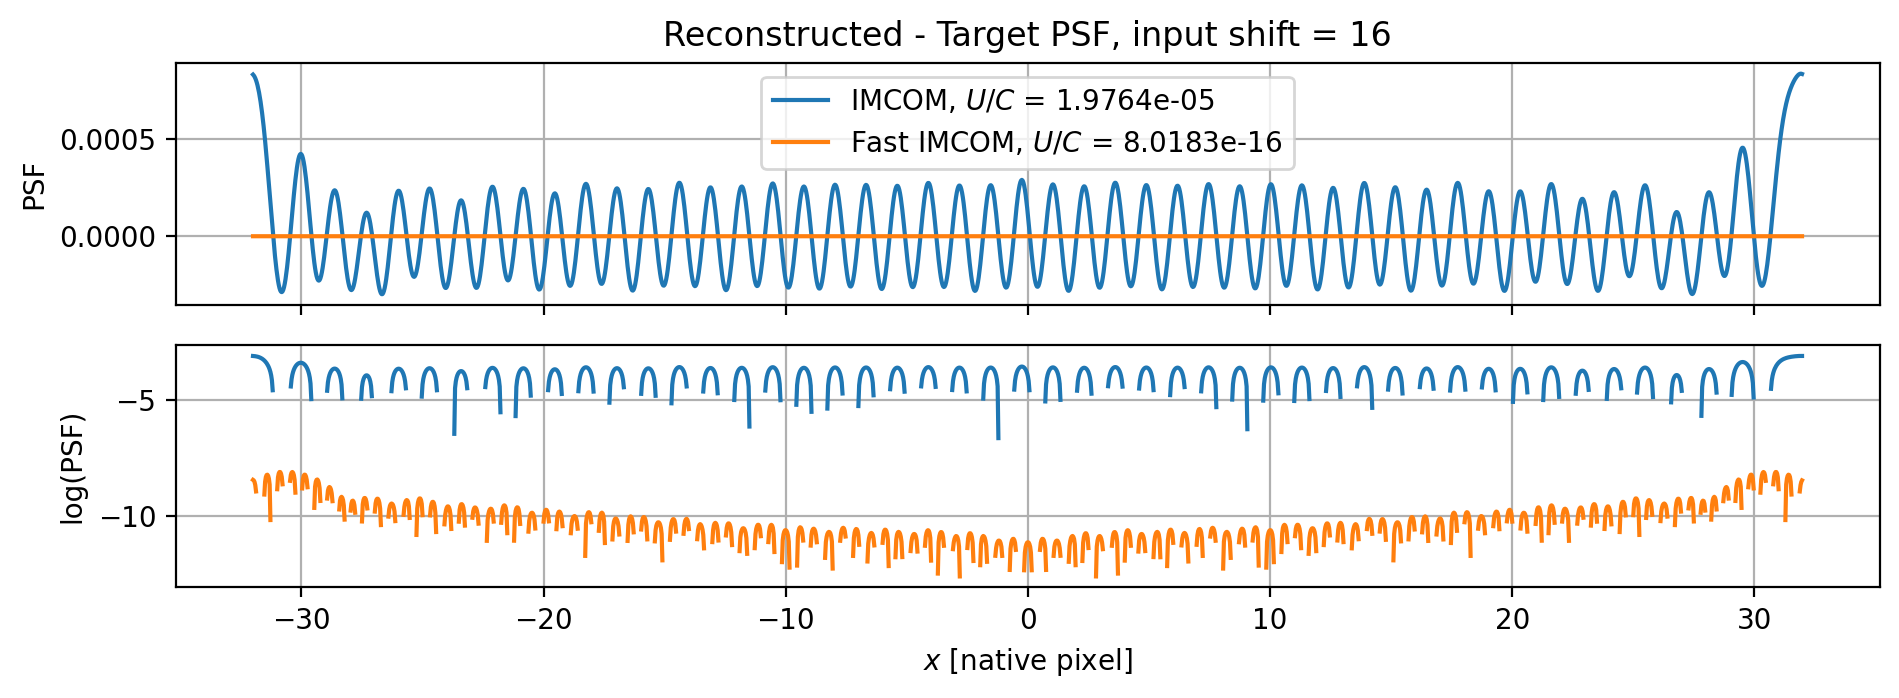

-2.3681147336418462e-06


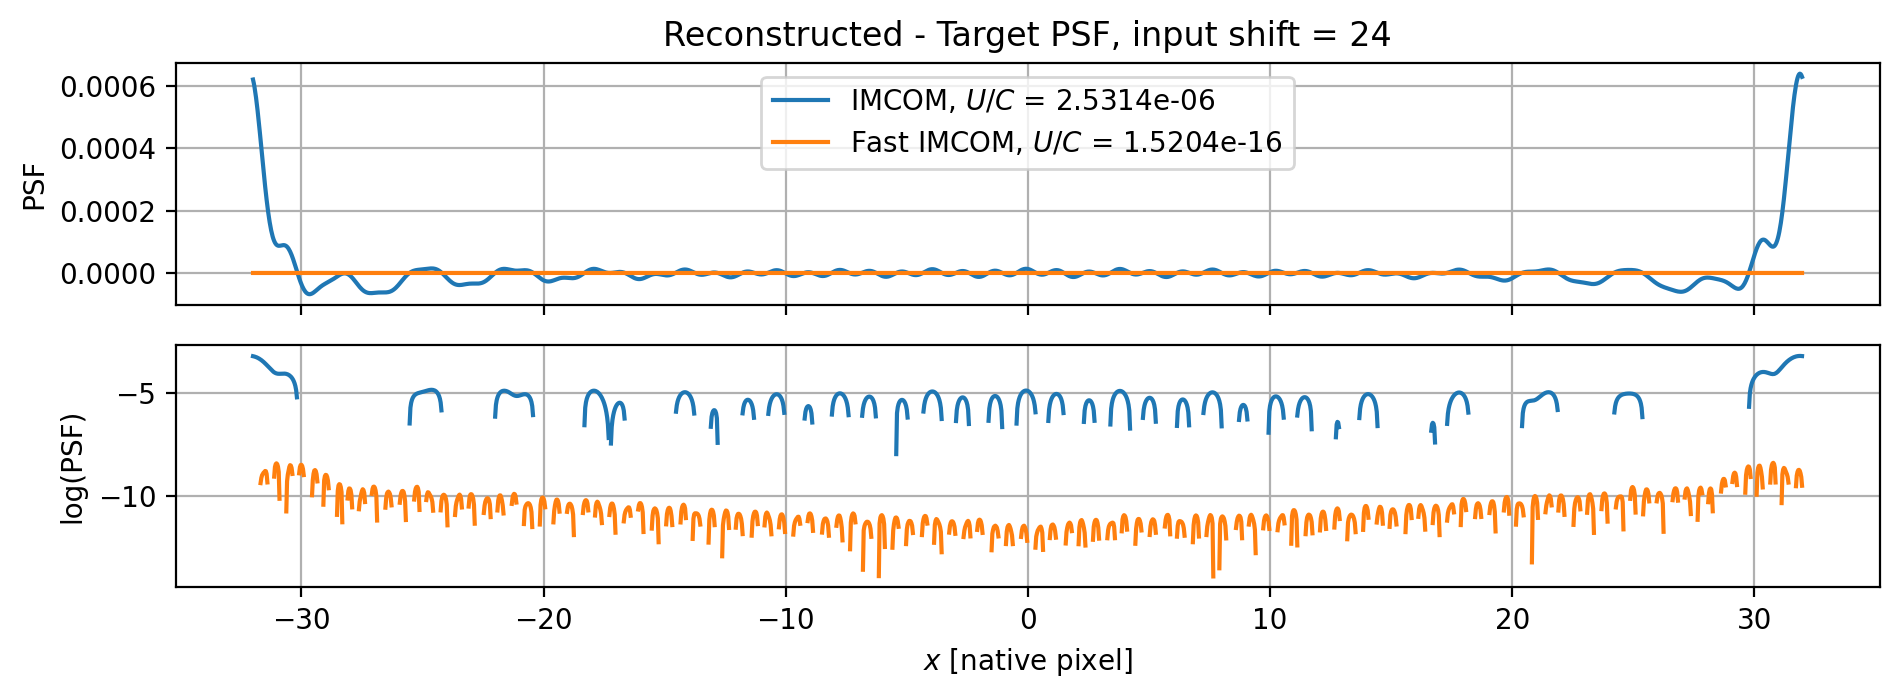

In [11]:
shift = 0  # Shift of the output pixel.
for s in [2, 4, 6, 8, 12]:
    shifts = [0, s, s*2]  # Shifts of the input grids.
    meta_weights = get_meta_weights(shifts)
    Amat, Ainv, Bmat, Tmat = explore_case(ovl_ii, ovl_oi, shifts=shifts)

    my_weightu_i = np.zeros_like(weight)
    my_weightu_f = np.zeros_like(weight)
    for i, s in enumerate(shifts):
        my_weightu_i[s+shift::SAMP] = Tmat[shift, i*NPIX:(i+1)*NPIX]
        my_weightu_f[s+shift::SAMP] = weight[s+shift::SAMP] * SAMP * meta_weights[i]
    print(np.einsum("ji,j,i->", Amat, Tmat[shift], Tmat[shift]) / C\
        - 2 * np.einsum("j,j->", Bmat[shift], Tmat[shift]) / C + 1)

    visualize_case(my_weightu_i, my_weightu_f,
                   psf_inp_t, psf_out, f"input shift = {s:d}")

3.721673982326479e-07


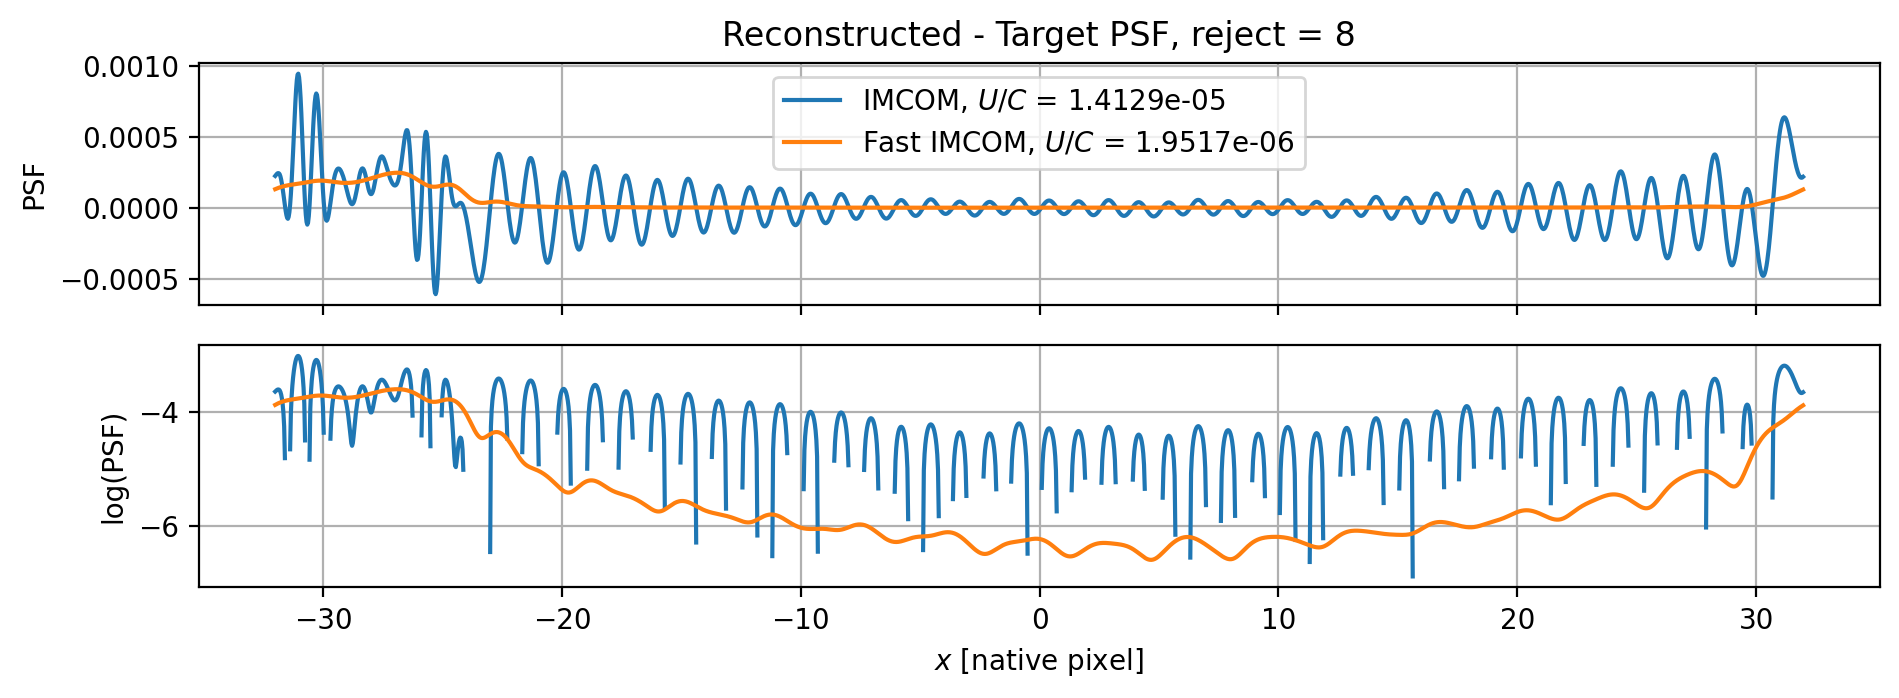

5.657663064262408e-06


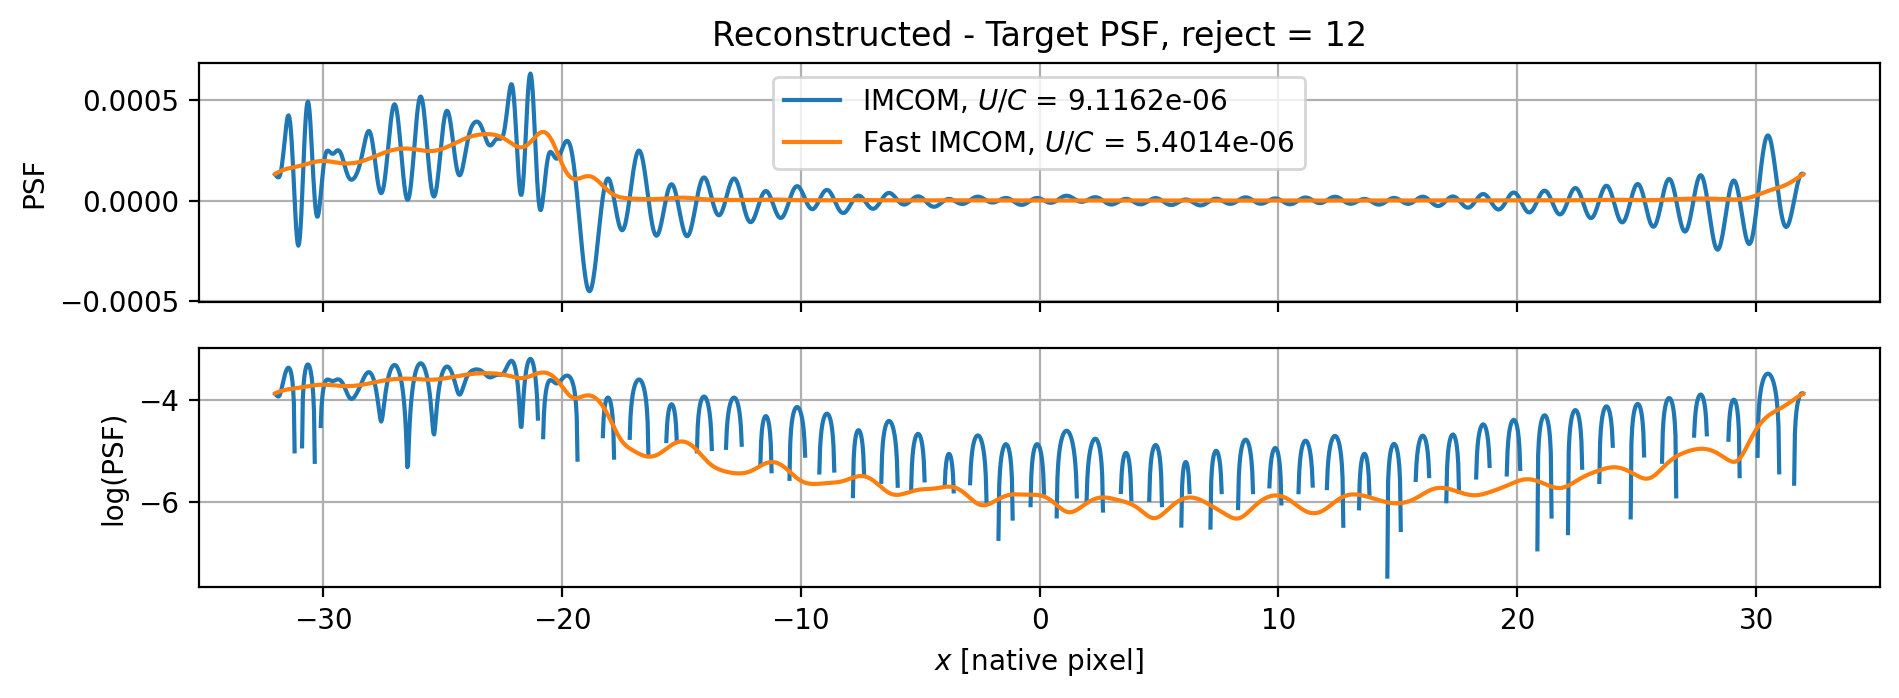

1.258733144582358e-05


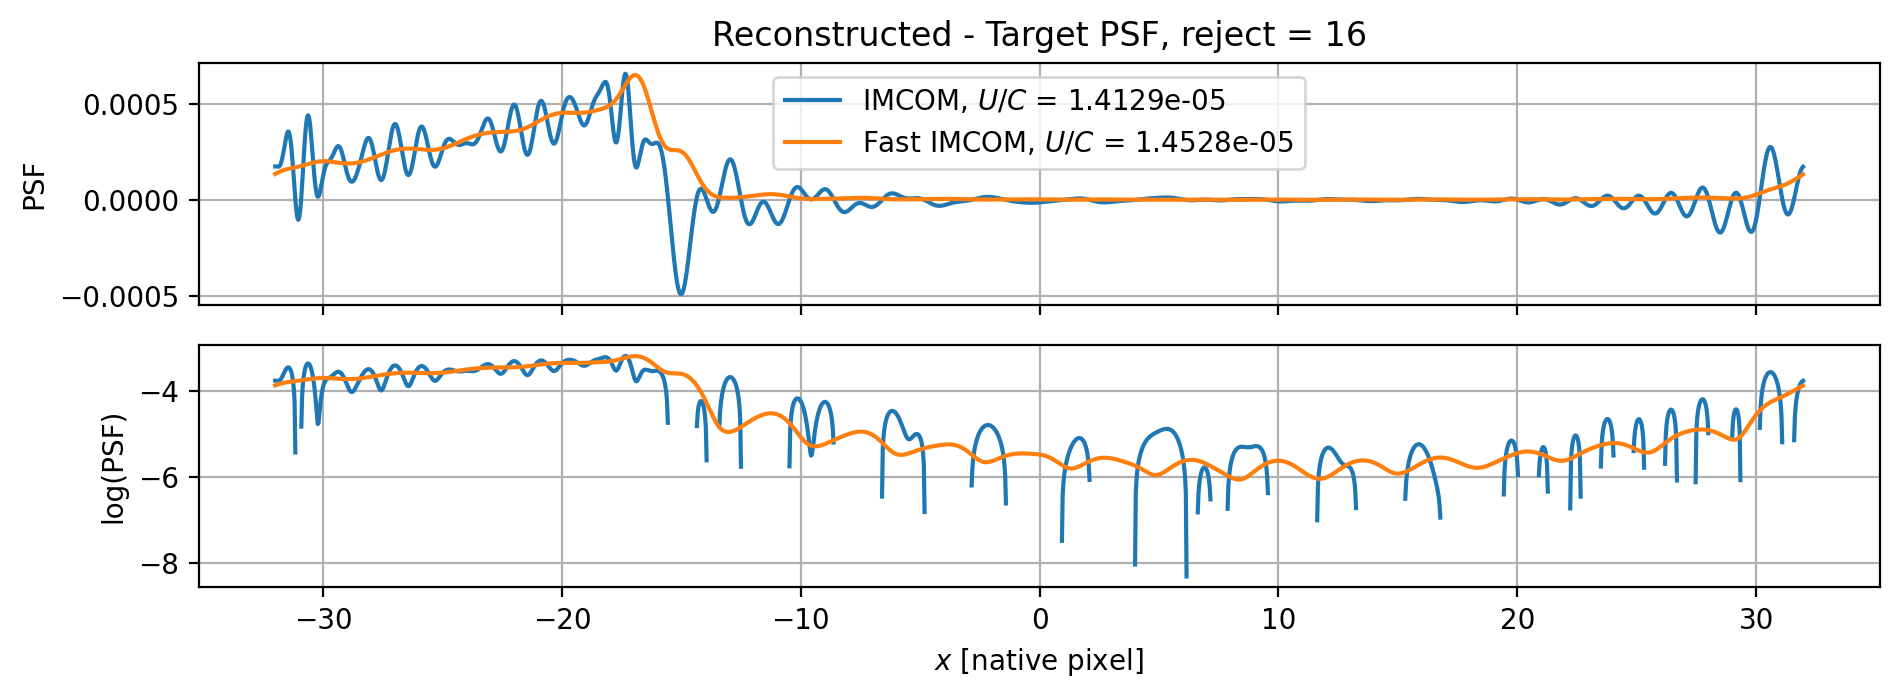

3.200902484523649e-05


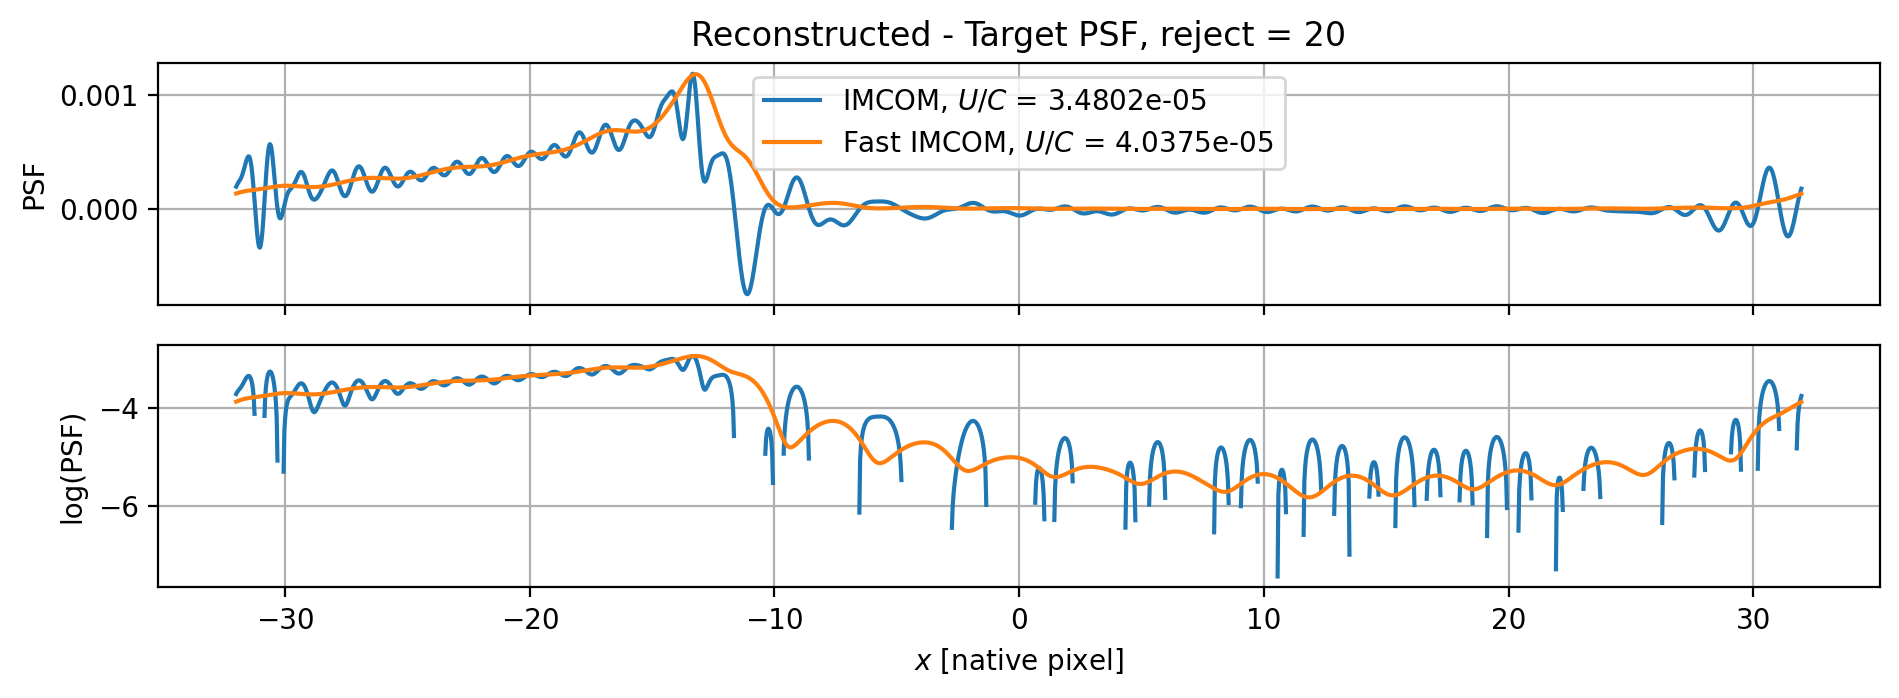

0.00011089020989085707


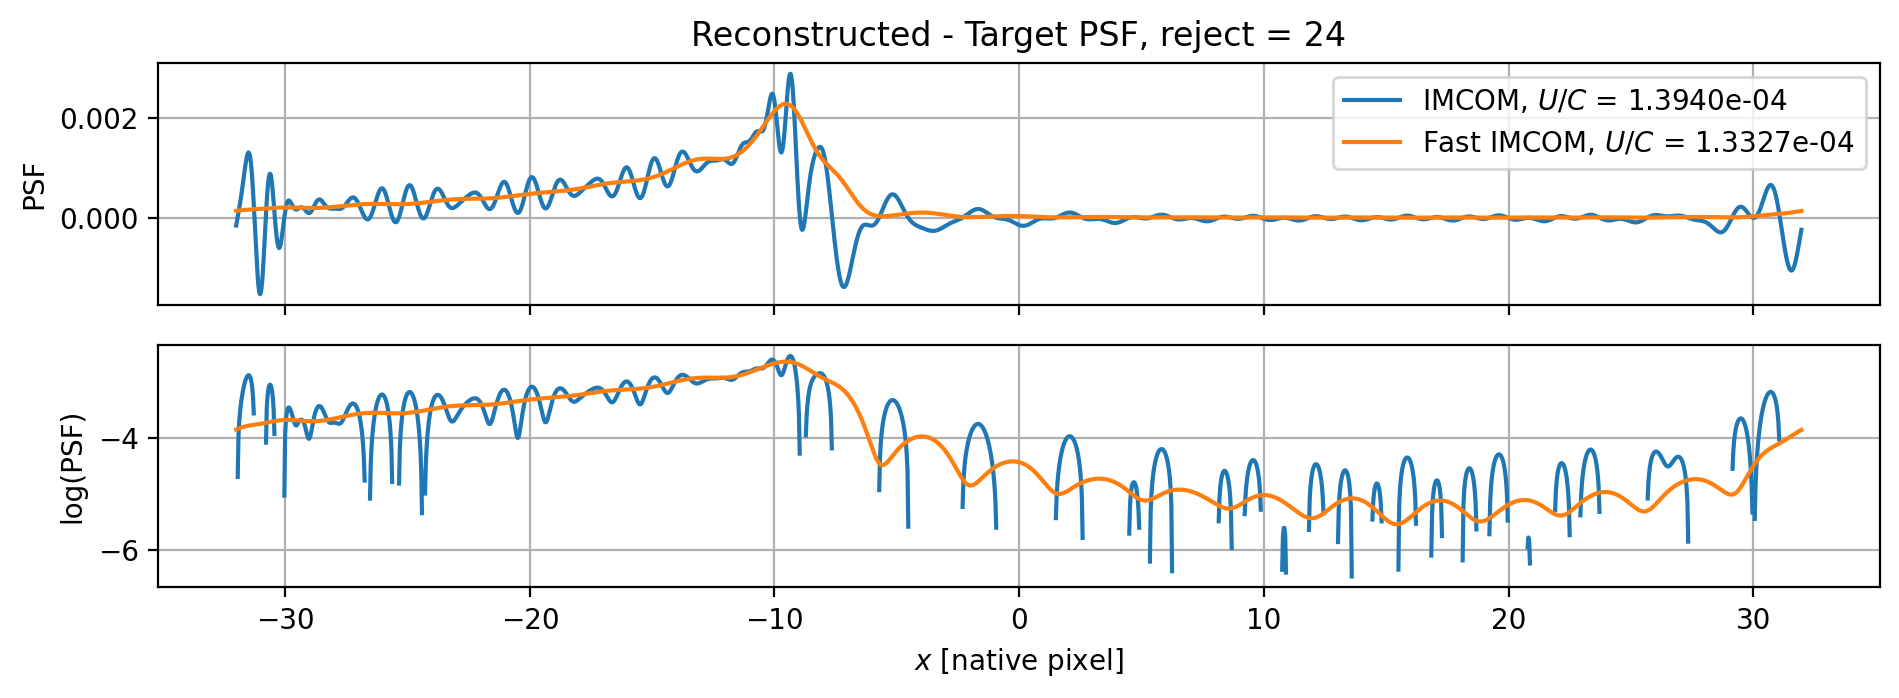

In [12]:
shift = 0  # Shift of the output pixel.
shifts = [0, 11, 21]  # Shifts of the input grids.
meta_weights = get_meta_weights(shifts)

for reject in [8, 12, 16, 20, 24]:
    Amat, Ainv, Bmat, Tmat = explore_case(
        ovl_ii, ovl_oi, shifts=shifts, reject=reject)
    npix = NPIX - reject

    my_weightu_i = np.zeros_like(weight)
    my_weightu_f = np.zeros_like(weight)
    for i, s in enumerate(shifts):
        my_weightu_i[reject*SAMP+s+shift::SAMP] = Tmat[shift, i*npix:(i+1)*npix]
        my_weightu_f[reject*SAMP+s+shift::SAMP] = weight[reject*SAMP+s+shift::SAMP] * SAMP * meta_weights[i]
    print(np.einsum("ji,j,i->", Amat, Tmat[shift], Tmat[shift]) / C\
        - 2 * np.einsum("j,j->", Bmat[shift], Tmat[shift]) / C + 1)

    visualize_case(my_weightu_i, my_weightu_f,
                   psf_inp_t, psf_out, f"{reject = :d}")